# 0. SETUP

## 0.1. Módulos comuns

In [1]:
from numpy import *
from numpy.linalg import *
from matplotlib.pyplot import *
from matplotlib.collections import PatchCollection

from scipy.optimize import minimize

## 0.2. Parâmetros do problema

In [2]:
SCALE = 1.0 # How much each screen element is going to be scaled. Default is 1.0
SCREEN_HEIGHT = 30 # The height of the screen that contains the overlapping windows in pixels
SCREEN_WIDTH = 30 # The width of the screen that contains the overlapping windows in pixels
MAX_WINDOW_DIM = 3 # The max height or width each window can have. For the project the default is 3.
MIN_WINDOW_DIM = 2 # The minimum height or width each window can have. For the project the default is 2.
CLUSTER_DISTANCE_FROM_SCREEN_CENTER = 7 # The distance from the clusters to the screen center in pixels
POINT_DISTANCE_FROM_CLUSTER = 4 # How far the points can be from the cluster in pixels
KNN_K = 5 # The number of closest neighbors considered for building the connectivity graph

## 0.3. Preprocessamento dos parâmetros

In [3]:
# Rescale
SCREEN_HEIGHT *= SCALE
SCREEN_WIDTH *= SCALE
MAX_WINDOW_DIM *= SCALE
MIN_WINDOW_DIM *= SCALE
CLUSTER_DISTANCE_FROM_SCREEN_CENTER *= SCALE
POINT_DISTANCE_FROM_CLUSTER *= SCALE

SCREEN_CENTER = array([ floor(SCREEN_WIDTH/2), floor(SCREEN_HEIGHT/2) ])

# 1. PREPARAÇÃO DOS DADOS

Os vetores $P_j$ gerados possuem dimensão $4$: a posição $x$ e $y$ (coluna) da origem do retângulo (ponto superior esquerdo), a altura do retângulo $h$ e a largura $w$, de forma que $P_j=(x_j,y_j,h_j,w_j)$. A nivel de implementação, o ponto ainda possui a informação do cluster ao qual ele pertence.

## 1.1 Gerar Centros

In [4]:
n_groups = random.randint(3,7)
angle_between_points = (2.0 * pi / n_groups * arange(0 , n_groups)) # The array of the angle of each cluster w.r.t. the x-axis

clusters = transpose( # Each row is a pair x,y from each cluster
    array( [
        CLUSTER_DISTANCE_FROM_SCREEN_CENTER * cos( angle_between_points ) + SCREEN_CENTER[0],
        CLUSTER_DISTANCE_FROM_SCREEN_CENTER * sin( angle_between_points ) + SCREEN_CENTER[1]
    ] )
)

## 1.2 Gerar pontos ao redor dos centros

In [5]:
size_groups = random.randint(5, 16, n_groups)
points = zeros((sum(size_groups),5)) #

j = 0
for cluster_idx in range(n_groups):
    for idx in range(size_groups[cluster_idx]):
        # Point position
        points[j,:2] = clusters[cluster_idx] + random.randint(-POINT_DISTANCE_FROM_CLUSTER/2,POINT_DISTANCE_FROM_CLUSTER/2, 2)
        # Point dimension
        points[j,2:4] = random.randint(MIN_WINDOW_DIM,MAX_WINDOW_DIM+1,2)
        # cluster_information
        points[j,4] = cluster_idx
        j += 1
        
points_pos = points[:,:2] # position vectors
points_dims = points[:,2:4] # dimension vectors

## 1.3 Mostrar os dados

<Figure size 432x288 with 0 Axes>

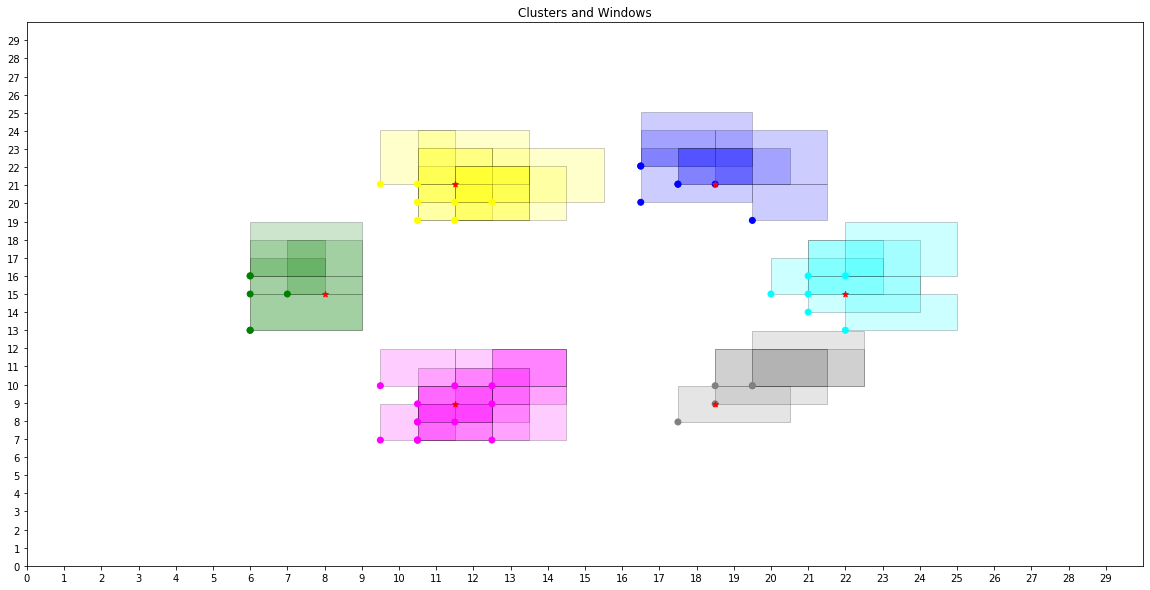

In [6]:
def draw_windows(window_clusters, window_points, window_dims, window_cluster_ids, n_clusters, group_size_list):
    clf()
    fig, ax = subplots(1, figsize=(20,10))
    ax.set_title("Clusters and Windows")
    ax.set_xlim(0, SCREEN_WIDTH)
    ax.set_ylim(0, SCREEN_HEIGHT)
    ax.set_xticks(arange(0, SCREEN_WIDTH, 1 * SCALE))
    ax.set_yticks(arange(0, SCREEN_HEIGHT, 1 * SCALE))
    
    # Draw Rectangles
    rect_clusters_list = [[] for i in range(n_clusters)]
    for j in range(sum(group_size_list)):
        point = window_points[j]
        dim = window_dims[j]
        idx = window_cluster_ids[j]
        rect = Rectangle((point[0], point[1]), dim[0], dim[1])
        rect_clusters_list[int(idx)].append(rect)
    color_list = ["cyan", "blue", "yellow", "green", "magenta", "gray", "black"]
    for i in range(n_clusters):
        rect_list = rect_clusters_list[i]
        pc = PatchCollection(rect_list, facecolor=color_list[i], edgecolor="k", alpha=0.2)
        ax.add_collection(pc)
        
    # Plot points
    colors_idx=window_cluster_ids[:].astype('int32')
    colors = [ color_list[color_idx] for color_idx in colors_idx]
    scatter(window_points[:,0], window_points[:,1], c=colors)

    # Plot Clusters
    ax.scatter(window_clusters[:,0], window_clusters[:,1], c="red", marker="*")
    return

draw_windows(clusters, points_pos, points_dims, points[:,4], n_groups, size_groups)

# 2. Modelagem Matemática


O problema se resume a maximizar $E(X) = (1-\alpha) E_O(X) + \alpha E_N(X) $, em que $X=(x_j, y_j)$ e $\alpha \in [0,1]$. $E_0$ e $E_N$ são as funções de energia de overlap e a de relação entre os vizinhos. Mais detalhes sobre as funções podem ser encontradas [neste link](https://ieeexplore.ieee.org/abstract/document/6629989).

In [7]:
def plus_operator(val):
    if val > 0:
        return val
    return 0.0

def O_ij(s_i, delta_s_i, s_j, delta_s_j):
    ret_val = 0
    if(s_i >= s_j):
        ret_val =  (1./(delta_s_j ** 4)) * plus_operator(delta_s_j ** 2 - (s_i - s_j) ** 2) ** 2
    else:
        ret_val =  (1./(delta_s_i ** 4)) * plus_operator(delta_s_i ** 2 - (s_i - s_j) ** 2) ** 2
    return ret_val

def check_connected(i, G, V, adjacency_list):
    N = G.shape[0]
    if V[i] == 0: # not visited
        adjacency_list.append(i)
        V[i] = 1
        for idx in range(N):
            if G[i,idx] != 0: # is connected
                check_connected(idx, G, V, adjacency_list) 
    return

def components_distance(X, c1, c2):
    """
    Compute the minimum distance between two components.
    Parameters
    ----------------
    X: Nx2 array. 
        The set of x,y points.
    c1,c2: list.
        List of indices of unconnected points in the adjacency graph
    """
    min_dist = inf
    min_i = -1
    min_j = -1
    for i in c1:
        p_i = X[i]
        for j in c2:
            p_j = X[j]
            dist = linalg.norm(p_i - p_j)
            if min_dist > dist:
                min_dist = dist
                min_i = i
                min_j = j
    return {"dist" : min_dist, "c1_idx" : min_i, "c2_idx" : min_j}

def get_unconnected_components(G):
    """
    Returns a list of unconnected components. Each component is a 
    list of the connected vertices within it.
    """
    N = G.shape[0]
    V = zeros((N)) # Visited elements
    unconnected_components = []
    for i in range(N):
        adjacency_list = []
        check_connected(i, G, V, adjacency_list)
        if adjacency_list: # if list is not empty
            unconnected_components.append(adjacency_list)
    return unconnected_components

def adjacency_matrix(X, K=KNN_K):
    N = X.shape[0]
    # Distance matrix first
    D = empty((N,N))
    for i in range(N):
        for j in range(N):
            if i != j:
                D[i,j] = linalg.norm(X[i] - X[j])
            else:
                D[i,j] = inf
            
    # From distance matrix, find the K closest elements
    A = zeros((N,N))
    for i in range(N):
        # Gets the k indices that sorts ascending D[i]
        ids = argsort(D[i])
        k_ids = ids[:K]
        for idx in k_ids:
            A[i,idx] = 1.0
            A[idx,i] = 1.0
        A[i,i] = 0.0
    
    # Get unconnected components
    components = get_unconnected_components(A)
    # Check the closest edges between each component, being them different among them
    for i in range(len(components)):
        min_dist = inf
        min_result = {"i" : -1, "j" : -1}
        for j in range(i+1, len(components)):
            # Ignore connections inside the component
            if i == j:
                continue
            result = components_distance(X, components[i], components[j])
            if(result["dist"] < min_dist):
                min_dist = result["dist"]
                min_result["i"] = result["c1_idx"]
                min_result["j"] = result["c2_idx"]
        # Connect
        A[min_result["i"], min_result["j"]] = 1.0
        A[min_result["j"], min_result["i"]] = 1.0
    
    return A


def degree(G):
    """
    Returns the degree of each vertex of an adjacency graph G. The degree matrix is a diagonal
    matrix in which each non-zero element contains the degree of the vertex
    """
    N = G.shape[0]
    D = zeros((N))
    for from_idx in range(N):
        degree = 0.0
        for for_idx in range(N):
            if(G[from_idx, for_idx] != 0):
                degree += 1.0
        D[from_idx] = degree
    return D

def laplacian_graph(X):
    A = adjacency_matrix(X)
    D = degree(A)
    N = A.shape[0]
    L = zeros((N,N))
    for i in range(N):
        for j in range(N):
            if (i != j) and A[i,j] != 0:
                L[i,j] = -1.0 / (1.0 * D[i])
            elif i == j:
                L[i,j] = 1.0
    return L

In [30]:
def E_O(X):
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    sum_e = 0
    n = X.shape[0]
    for i in range(n):
        point_i = X[i]
        # Horizontal
        x_i = point_i[0]
        h_i = points_dims[i,0]
        # Vertical
        y_i = point_i[1]
        v_i = points_dims[i,1]
        for j in range(i+1,X.shape[0]):
            point_j = X[j]
            # Horizontal
            x_j = point_j[0]
            h_j = points_dims[j,0]
            overlapping_h = O_ij(x_i, h_i, x_j, h_j)
            # Vertical
            y_j = point_j[1]
            v_j = points_dims[j,1]
            overlapping_v = O_ij(y_i, v_i, y_j, v_j)
            # Sum
            sum_e += overlapping_h * overlapping_v
    sum_e = 2.0 / (n * (n+1) ) * sum_e
    return sum_e

# For the sake of processing time reduction
_LAPLACIAN_L = laplacian_graph(points_pos)
_DELTA_X = _LAPLACIAN_L.dot(points_pos[:,0])
_DELTA_Y = _LAPLACIAN_L.dot(points_pos[:,1])
def E_N(X):
    N = points.shape[0]
    w = X[-1]
    X = reshape(X[:-1], (points.shape[0], 2)) # Removes w from the state
    delta_x = _DELTA_X
    delta_y = _DELTA_Y
    L = _LAPLACIAN_L
    norm_factor = (N ** 2.0)/( 2.0 * (linalg.norm(delta_x) ** 2 +linalg.norm(delta_y) ** 2) )
    diff_x = linalg.norm( L.dot(X[:,0]) - w * delta_x ) ** 2
    print( L.dot(X[:,0]) - w * delta_x )
    diff_y = linalg.norm(L.dot(X[:,1]) - w * delta_y) ** 2 
    diff_factor = ( diff_x + diff_y)
    sum_e = norm_factor * diff_factor
    return sum_e

# 3. Solução Numérica

In [31]:
alpha = 0.9
def f (x):
    e_n = E_N(x)
    e_o = E_O(x)
    
    print("E_N(X)={} | E_O(X)={}".format(e_n, e_o) )
    return alpha * e_n + (1- alpha) * e_o

## RESTRICOES
#### ATENCAO: AS RESTRICOES DE DESIGUALDADE NO SCIPY SAO O OPOSTO: SAO DO TIPO r(X) >= 0!
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
x_min = 0
x_max = SCREEN_WIDTH
y_min = 0
y_max = SCREEN_HEIGHT

# r1: x_min-x_i <= 0 
#     <=> x_i - x_min >= 0
def constr_fun_1(X):
    """
    X is the matrix (N,2) of points.
    """
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        #constr[i] = x_min - X[i,0]
        constr[i] = X[i,0] - x_min
    return constr

# r2: x_i - x_max + h_i <= 0 
#     <=> x_max - x_i - h_i >= 0
def constr_fun_2(X):
    """
    X is the matrix (N,2) of points.
    """
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        #constr[i] = - x_max + X[i,0] + points_dims[i,0]
        constr[i] = x_max - X[i,0] - points_dims[i,0] - 1
    return constr

# r3: y_min-y_i <= 0 
#     <=> y_i - y_min >= 0
def constr_fun_3(X):
    """
    X is the matrix (N,2) of points.
    """
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        constr[i] = X[i,1] -  y_min
        #constr[i] = -X[i,1] + y_min
    return constr

# r4: y_i - y_max + v_i <= 0
#     <=> y_max - y_i - v_i >= 0
def constr_fun_4(X):
    """
    X is the matrix (N,2) of points.
    """
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        constr[i] = x_max - X[i,1]  - points_dims[i,1] - 1
        #constr[i] = - x_max + X[i,1]  + points_dims[i,1]
    return constr


cons = (
    {'type': 'ineq', 'fun':  constr_fun_1},
    {'type': 'ineq', 'fun':  constr_fun_2},
    {'type': 'ineq', 'fun':  constr_fun_3},
    {'type': 'ineq', 'fun':  constr_fun_4},
)

bounds = []
for idx in range(points_pos.shape[0]):
    point_bound_x = (x_min, x_max - points_dims[idx,0]-1)
    point_bound_y = (y_min, y_max - points_dims[idx,1]-1)
    bounds.append(point_bound_x)
    bounds.append(point_bound_y)
    
w_init = 1.0
X_init = append(points_pos.flatten(), [w_init])
res = minimize(f, X_init, method='SLSQP', constraints=cons, tol=1e-9, options={"maxiter" : 5e1})
X_final = reshape(res["x"][:-1], (points.shape[0], 2))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
E_N(X)=0.0 | E_O(X)=0.05576768135908265
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
E_N(X)=0.0 | E_O(X)=0.05576768135908265
[ 1.49011612e-08 -2.98023295e-09 -2.48352627e-09 -2.98023295e-09
 -1.65568537e-09 -2.98023295e-09  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
E_N(X)=4.0385070830284725e-15 | E_O(X)=0.05576768137945073
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.12873719e-09  0.00000000e+00
 -1.65568537e-09 -2.12873719e-09  0.00000000e+00  0.00000000e+00
  1.49011612e-08 -2.12873807e-09 -2.98023117e-09  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]
E_N(X)=3.957042772021872e-15 | E

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.65568359e-09  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.98023295e-09  1.49011612e-08
 -2.98023295e-09 -2.98023295e-09 -2.48352805e-09]
E_N(X)=4.122468947386522e-15 | E_O(X)=0.055767681364394125
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
E_N(X)=4.1224687167559274e-15 | 

E_N(X)=1.7011487060757047e-08 | E_O(X)=0.05576737519250302
[-4.33609868e-06  1.82279647e-07 -1.65750823e-06  4.88840146e-06
  1.47998302e-06 -9.17229476e-08 -3.15606587e-06 -3.12592562e-06
  6.62481886e-07  6.72277574e-06  1.80284394e-06 -3.50520561e-08
 -4.34849689e-06 -6.01967088e-06 -2.78579155e-06  6.01563280e-06
 -4.31497832e-06 -2.39049547e-06  4.46626167e-06  5.36728660e-06
 -5.22912266e-06  4.38050226e-06  2.13189427e-06 -2.57044956e-06
 -2.05027815e-06  6.70497837e-06 -9.19717473e-08 -1.12350965e-06
 -4.94917122e-07 -1.50473131e-06  2.97851125e-06 -4.11640176e-06
 -2.60753632e-06  4.28490229e-06  2.39252464e-06  9.46713007e-07
  1.04283191e-06 -8.90405584e-06  5.05535447e-07  9.30312752e-08
 -3.97037137e-07  2.03758025e-06 -1.50879710e-06 -1.86494583e-06
  2.35298912e-06 -3.14731320e-06  3.77945433e-06]
E_N(X)=1.7009250542588432e-08 | E_O(X)=0.055767375222004166
[-4.33609868e-06  1.82279647e-07 -1.65750823e-06  4.88840146e-06
  1.47998302e-06 -9.17229476e-08 -3.15606587e-06 -3

[-4.33609868e-06  1.82279647e-07 -1.65750823e-06  4.88840146e-06
  1.47998302e-06 -9.17229476e-08 -3.15606587e-06 -3.12592562e-06
  6.62481886e-07  6.72277574e-06  1.80284394e-06 -3.50520561e-08
 -4.34849689e-06 -6.01718735e-06 -2.78366281e-06  6.01563280e-06
 -4.31332263e-06 -2.40539663e-06  4.46874520e-06  5.36977013e-06
 -5.22614242e-06  4.38050226e-06  2.13487450e-06 -2.57044956e-06
 -2.05027815e-06  6.70497837e-06 -9.19717473e-08 -1.12350965e-06
 -4.94917122e-07 -1.50771155e-06  2.97851125e-06 -4.11853050e-06
 -2.60753632e-06  4.28341218e-06  2.39252464e-06  9.44229479e-07
  1.04070317e-06 -8.90703608e-06  5.03406711e-07  1.07932436e-07
 -3.98692822e-07  2.03758025e-06 -1.50879710e-06 -1.86494583e-06
  2.35298912e-06 -3.14731320e-06  3.77945433e-06]
E_N(X)=1.7010942036842036e-08 | E_O(X)=0.05576737520968103
[-4.33609868e-06  1.82279647e-07 -1.65750823e-06  4.88840146e-06
  1.47998302e-06 -9.17229476e-08 -3.15606587e-06 -3.12592562e-06
  6.62481886e-07  6.72277574e-06  1.80284394e-

[-8.62959504e-07  1.24782317e-06 -3.22521050e-06  3.67923172e-06
 -6.27844232e-06  7.79884725e-07 -1.67169310e-06 -1.62021988e-06
  1.11202169e-06  6.02555567e-06  3.07949481e-06 -6.09351303e-06
 -5.40578830e-06 -1.14335126e-05 -3.50732437e-06  8.03140032e-06
 -5.30353999e-06 -3.52637194e-06  6.14641109e-06  7.68721877e-06
 -3.40052219e-06  4.92229758e-06  3.56488552e-06 -3.44843237e-06
 -2.56008957e-06  1.02332791e-05  7.84282158e-07 -9.77365405e-07
  9.61371976e-08  3.92524088e-06  1.38876855e-06 -3.69211519e-06
 -5.38028954e-06  5.51937465e-06 -1.49356321e-06  2.36051913e-06
  3.11438764e-06 -1.05900678e-05  2.19472670e-06 -4.94768186e-07
 -2.06430627e-07  2.02959618e-06 -1.63562920e-06  1.02346996e-06
  2.62115934e-06 -1.16654157e-06 -9.88343051e-06]
E_N(X)=3.2394723615352305e-08 | E_O(X)=0.055767154970769686
[-8.62959504e-07  1.24782317e-06 -3.22521050e-06  3.67923172e-06
 -6.27844232e-06  7.79884725e-07 -1.66871287e-06 -1.61723964e-06
  1.11450522e-06  6.02803919e-06  3.06459365e

E_N(X)=3.2389624835494095e-08 | E_O(X)=0.055767154984589805
[-8.62959504e-07  1.24782317e-06 -3.22521050e-06  3.67923172e-06
 -6.27844232e-06  7.79884725e-07 -1.66871287e-06 -1.61723964e-06
  1.11450522e-06  6.02803919e-06  3.06459365e-06 -6.09053280e-06
 -5.40365957e-06 -1.14335126e-05 -3.50732437e-06  8.03140032e-06
 -5.30353999e-06 -3.52637194e-06  6.14641109e-06  7.68721877e-06
 -3.40052219e-06  4.92229758e-06  3.56488552e-06 -3.44843237e-06
 -2.56008957e-06  1.02332791e-05  7.84282158e-07 -9.77365405e-07
  9.61371976e-08  3.92524088e-06  1.38876855e-06 -3.69211519e-06
 -5.38028954e-06  5.51937465e-06 -1.49356321e-06  2.36051913e-06
  3.11438764e-06 -1.05900678e-05  2.19472670e-06 -4.94768186e-07
 -2.06430627e-07  2.02959618e-06 -1.63562920e-06  1.02346996e-06
  2.62115934e-06 -1.16654157e-06 -9.88343051e-06]
E_N(X)=3.239440508269472e-08 | E_O(X)=0.055767154959707514
[-8.62959504e-07  1.24782317e-06 -3.22521050e-06  3.67923172e-06
 -6.27844232e-06  7.79884725e-07 -1.66871287e-06 -1

[-9.99749371e-07 -3.19694414e-08 -1.00576905e-05  1.20447382e-06
 -1.23543731e-05 -3.98052683e-07  1.23692020e-06  1.27719333e-06
 -2.87790204e-06  1.48596230e-06 -9.44677053e-07 -7.12183909e-06
 -2.82686584e-06 -9.28153612e-06 -1.41634495e-05  1.86673487e-05
 -4.82280833e-06 -1.21492726e-05  1.05647464e-05  1.20922511e-05
 -9.73266391e-06  2.09897944e-05 -4.96707877e-06  5.47884979e-07
  1.24285455e-06  9.44755213e-07  3.85902566e-06  2.48098810e-06
  3.32072767e-06  2.10674710e-06 -1.71443569e-06 -3.87529343e-06
 -3.99878652e-06  1.23580567e-05 -5.49977054e-06 -8.33434392e-07
  4.38335250e-06 -1.26193908e-05  3.33763424e-06 -1.43169655e-06
 -1.56546479e-06  1.59290470e-05 -4.28087808e-06 -7.40998115e-06
 -6.84355317e-06 -9.12317411e-06 -1.94214167e-05]
E_N(X)=8.709241124889776e-08 | E_O(X)=0.055766257813268695
[-9.96769138e-07 -2.89892085e-08 -1.00552070e-05  1.18957266e-06
 -1.23527174e-05 -3.95072450e-07  1.23692020e-06  1.27719333e-06
 -2.87790204e-06  1.48596230e-06 -9.44677053e-

[-9.96769138e-07 -2.89892085e-08 -1.00552070e-05  1.18957266e-06
 -1.23527174e-05 -3.95072450e-07  1.23692020e-06  1.27719333e-06
 -2.87790204e-06  1.48596230e-06 -9.44677053e-07 -7.12183909e-06
 -2.82686584e-06 -9.28153612e-06 -1.41634495e-05  1.86673487e-05
 -4.82280833e-06 -1.21492726e-05  1.05647464e-05  1.20922511e-05
 -9.73266391e-06  2.09897944e-05 -4.96707877e-06  5.44904747e-07
  1.23987432e-06  9.42271686e-07  3.85604542e-06  2.49588926e-06
  3.31774743e-06  2.10674710e-06 -1.71443569e-06 -3.87529343e-06
 -3.99878652e-06  1.23580567e-05 -5.49977054e-06 -8.33434392e-07
  4.38335250e-06 -1.26193908e-05  3.33763424e-06 -1.43169655e-06
 -1.56546479e-06  1.59290470e-05 -4.28087808e-06 -7.40998115e-06
 -6.84355317e-06 -9.12317411e-06 -1.94214167e-05]
E_N(X)=8.709050707160284e-08 | E_O(X)=0.05576625783509289
[-9.96769138e-07 -2.89892085e-08 -1.00552070e-05  1.18957266e-06
 -1.23527174e-05 -3.95072450e-07  1.23692020e-06  1.27719333e-06
 -2.87790204e-06  1.48596230e-06 -9.44677053e-0

E_N(X)=1.4146425542190247e-05 | E_O(X)=0.05574934494525056
[-6.30432264e-06 -8.29213945e-06 -7.22453274e-06 -1.05242160e-05
 -3.00178779e-05 -7.93578464e-06 -1.02206770e-06 -1.06127254e-06
 -4.73380204e-06 -8.83506332e-06 -6.16971828e-06 -1.28592683e-05
  1.10188712e-05 -8.79101324e-06 -5.19225368e-06  1.85507753e-05
  5.96074201e-06 -2.09984361e-05  2.20759669e-05  2.09414108e-05
 -1.38943061e-05  8.85055036e-06 -1.95801642e-05  8.30552093e-06
  7.62889073e-06 -2.28403463e-06  5.08122384e-06  6.42321246e-06
  5.60544425e-06  1.61015441e-06  1.12595153e-05 -1.86740484e-06
 -7.21503209e-08  7.67909886e-06 -2.19373681e-06  4.19761341e-06
  9.15388615e-06  5.26456923e-07  9.76796303e-06 -3.03723403e-06
 -7.01505534e-06  1.24589770e-05 -1.16199198e-05 -2.97734575e-05
 -3.13704020e-05 -2.81052755e-05 -2.38290968e-05]
E_N(X)=2.2513126734932538e-07 | E_O(X)=0.05576456658207654
[-6.30432264e-06 -8.29213945e-06 -7.22453274e-06 -1.05242160e-05
 -3.00178779e-05 -7.93578464e-06 -1.02206770e-06 -1.

[-6.30432264e-06 -8.29213945e-06 -7.22453274e-06 -1.05242160e-05
 -3.00178779e-05 -7.93578464e-06 -1.02206770e-06 -1.06127254e-06
 -4.73380204e-06 -8.83506332e-06 -6.16971828e-06 -1.28592683e-05
  1.10188712e-05 -8.79101324e-06 -5.19438242e-06  1.85507753e-05
  5.95908632e-06 -2.10005648e-05  2.20759669e-05  2.09414108e-05
 -1.38794050e-05  8.84842163e-06 -1.95831444e-05  8.30552093e-06
  7.62889073e-06 -2.28403463e-06  5.08122384e-06  6.42321246e-06
  5.60544425e-06  1.61015441e-06  1.12595153e-05 -1.86740484e-06
 -7.21503209e-08  7.67909886e-06 -2.19373681e-06  4.19761341e-06
  9.15388615e-06  5.26456923e-07  9.76796303e-06 -3.03723403e-06
 -7.01505534e-06  1.24589770e-05 -1.16199198e-05 -2.97734575e-05
 -3.13704020e-05 -2.81052755e-05 -2.38290968e-05]
E_N(X)=2.2512737785306284e-07 | E_O(X)=0.055764566610698084
[-6.30432264e-06 -8.29213945e-06 -7.22453274e-06 -1.05242160e-05
 -3.00178779e-05 -7.93578464e-06 -1.02206770e-06 -1.06127254e-06
 -4.73380204e-06 -8.83506332e-06 -6.16971828e

[-6.30432264e-06 -8.29213945e-06 -7.22453274e-06 -1.05242160e-05
 -3.00178779e-05 -7.93578464e-06 -1.02206770e-06 -1.06127254e-06
 -4.73380204e-06 -8.83506332e-06 -6.16971828e-06 -1.28592683e-05
  1.10188712e-05 -8.79101324e-06 -5.19225368e-06  1.85507753e-05
  5.96074201e-06 -2.09984361e-05  2.20759669e-05  2.09414108e-05
 -1.38943061e-05  8.85055036e-06 -1.95801642e-05  8.30552093e-06
  7.62889073e-06 -2.28403463e-06  5.08122384e-06  6.42321246e-06
  5.60544425e-06  1.61015441e-06  1.12595153e-05 -1.86740484e-06
 -7.21503209e-08  7.67909886e-06 -2.19373681e-06  4.19761341e-06
  9.15388615e-06  5.26456923e-07  9.76796303e-06 -3.03723403e-06
 -7.01505534e-06  1.24589770e-05 -1.16199198e-05 -2.97734575e-05
 -3.13704020e-05 -2.81052755e-05 -2.38290968e-05]
E_N(X)=2.2512421956579077e-07 | E_O(X)=0.05576456658990506
[-6.30432264e-06 -8.29213945e-06 -7.22453274e-06 -1.05242160e-05
 -3.00195336e-05 -7.93578464e-06 -1.02206770e-06 -1.06127254e-06
 -4.73380204e-06 -8.83506332e-06 -6.16971828e-

[-2.13981455e-05 -1.69058115e-05 -1.56022522e-05 -1.22229493e-05
 -5.92349238e-05 -1.71840519e-05 -8.64230203e-06 -8.61172891e-06
 -2.98164410e-06  2.65582840e-07 -2.83637655e-06 -2.46211603e-06
 -8.17991414e-06  5.57794492e-06 -4.11190896e-06  2.77250116e-05
 -2.61601532e-07  6.17807637e-06  1.14229839e-05  1.15376828e-05
 -1.60033138e-05 -1.16506453e-05 -8.62618371e-06  4.12126412e-06
  4.64927586e-06  2.44208745e-05  6.63670010e-06  5.58975050e-06
  6.22777212e-06 -8.23191127e-06  1.68982863e-05 -5.83912096e-07
  5.72309961e-06  2.06664907e-06  1.07017854e-05  1.48336005e-05
  8.01581363e-06  5.84531757e-06  8.28213328e-06  6.97327916e-06
  5.64644991e-06 -2.06962648e-06 -4.51387528e-05 -4.41645563e-05
 -3.99771895e-05 -4.54661740e-05 -3.71689299e-05]
E_N(X)=3.871218065211164e-07 | E_O(X)=0.0557626298890012
[-2.13981455e-05 -1.69058115e-05 -1.56022522e-05 -1.22229493e-05
 -5.92349238e-05 -1.71840519e-05 -8.64230203e-06 -8.61172891e-06
 -2.98164410e-06  2.65582840e-07 -2.83637655e-06

[-2.13981455e-05 -1.69058115e-05 -1.56022522e-05 -1.22229493e-05
 -5.92349238e-05 -1.71840519e-05 -8.64230203e-06 -8.61172891e-06
 -2.98164410e-06  2.65582840e-07 -2.83637655e-06 -2.46211603e-06
 -8.17991414e-06  5.57794492e-06 -4.11190896e-06  2.77250116e-05
 -2.61601532e-07  6.17807637e-06  1.14229839e-05  1.15376828e-05
 -1.60033138e-05 -1.16506453e-05 -8.62618371e-06  4.12126412e-06
  4.64927586e-06  2.44208745e-05  6.63670010e-06  5.58975050e-06
  6.22777212e-06 -8.23191127e-06  1.68982863e-05 -5.83912096e-07
  5.72309961e-06  2.06664907e-06  1.07017854e-05  1.48336005e-05
  8.01581363e-06  5.84531757e-06  8.28213328e-06  6.97327916e-06
  5.64644991e-06 -2.06962648e-06 -4.51387528e-05 -4.41645563e-05
 -3.99771895e-05 -4.54661740e-05 -3.71689299e-05]
E_N(X)=3.871197088910953e-07 | E_O(X)=0.05576262986827462
[-2.13981455e-05 -1.69058115e-05 -1.56022522e-05 -1.22229493e-05
 -5.92365795e-05 -1.71840519e-05 -8.64230203e-06 -8.61172891e-06
 -2.98164410e-06  2.65582840e-07 -2.83637655e-0

[-2.61150142e-05 -2.09412535e-05 -2.17908082e-05 -1.55363469e-05
 -5.47405552e-05 -2.12788478e-05 -1.04690724e-05 -1.04319618e-05
 -4.27507543e-06  2.60711812e-06 -3.01978144e-06  2.50065859e-08
 -6.49180642e-06  9.42474527e-06 -1.13423092e-06  8.06175069e-06
 -2.08719105e-06  4.15212976e-06  1.12745620e-05  1.22663639e-05
 -1.30372553e-05 -2.65313552e-06 -4.36273095e-06  5.39398482e-06
  6.03465994e-06  2.14053867e-05  8.44611102e-06  7.17585411e-06
  7.94995773e-06 -4.95004825e-06  9.64288291e-06  2.53611032e-06
  2.47507136e-06  8.89111917e-06  1.28840993e-05  1.09699756e-05
  7.55455579e-06  2.62258677e-06  7.05909582e-06  6.69588513e-06
  9.56911272e-06 -4.11797987e-06 -4.58685065e-05 -4.91247706e-05
 -4.43209818e-05 -5.07040876e-05 -4.33066293e-05]
E_N(X)=4.025156688888278e-07 | E_O(X)=0.05576223716061509
[-2.61150142e-05 -2.09412535e-05 -2.17908082e-05 -1.55363469e-05
 -5.47405552e-05 -2.12788478e-05 -1.04690724e-05 -1.04319618e-05
 -4.27507543e-06  2.60711812e-06 -3.01978144e-0

E_N(X)=4.025141237168608e-07 | E_O(X)=0.05576223714193503
[-2.61150142e-05 -2.09412535e-05 -2.17908082e-05 -1.55363469e-05
 -5.47405552e-05 -2.12788478e-05 -1.04690724e-05 -1.04319618e-05
 -4.27507543e-06  2.60711812e-06 -3.01978144e-06  2.50065859e-08
 -6.49180642e-06  9.42722880e-06 -1.13210218e-06  8.06175069e-06
 -2.08553537e-06  4.13722860e-06  1.12770456e-05  1.22688474e-05
 -1.30342751e-05 -2.65313552e-06 -4.35975072e-06  5.39398482e-06
  6.03465994e-06  2.14053867e-05  8.44611102e-06  7.17585411e-06
  7.94995773e-06 -4.95004825e-06  9.63990268e-06  2.53398158e-06
  2.47209113e-06  8.88962906e-06  1.28990004e-05  1.09699756e-05
  7.55455579e-06  2.62258677e-06  7.05909582e-06  6.69588513e-06
  9.56745704e-06 -4.11797987e-06 -4.58685065e-05 -4.91247706e-05
 -4.43209818e-05 -5.07040876e-05 -4.33066293e-05]
E_N(X)=4.025183546982324e-07 | E_O(X)=0.055762237132010666
[-2.61150142e-05 -2.09412535e-05 -2.17908082e-05 -1.55363469e-05
 -5.47405552e-05 -2.12788478e-05 -1.04690724e-05 -1.0

[-2.85676857e-05 -2.46007347e-05 -2.24872742e-05 -2.06647012e-05
 -6.03598110e-05 -2.45559258e-05 -6.82325524e-06 -6.82820483e-06
 -2.02130078e-06  2.28488561e-06 -1.99500638e-06 -1.86006068e-06
 -1.43565662e-05  1.49544028e-06 -6.19618265e-06  6.42160735e-06
 -1.66533490e-07 -4.21502718e-07  7.50567472e-06  7.52645745e-06
 -1.13040741e-06  7.55181072e-06  2.36955139e-06  9.55675504e-06
  9.47140675e-06  1.49192201e-05  9.14949919e-06  9.31904817e-06
  9.21576891e-06  7.06327975e-06  9.67116205e-06  3.75568666e-06
  4.31967571e-06  1.51475437e-05  9.25953791e-06 -1.10054549e-06
  6.36656193e-06 -7.04847011e-06  6.18665338e-06  7.04789398e-06
  9.76312645e-06 -1.24333005e-06 -4.65030521e-05 -4.92299572e-05
 -4.52136277e-05 -4.90193977e-05 -3.49595126e-05]
E_N(X)=4.1311006764107355e-07 | E_O(X)=0.05576192344567354
[-2.85706659e-05 -2.45858335e-05 -2.24897578e-05 -2.06676814e-05
 -6.03614667e-05 -2.45589060e-05 -6.82325524e-06 -6.82820483e-06
 -2.02130078e-06  2.28488561e-06 -1.99500638e-

E_N(X)=4.1311054937147244e-07 | E_O(X)=0.05576192345252472
[-2.85676857e-05 -2.46007347e-05 -2.24872742e-05 -2.06647012e-05
 -6.03598110e-05 -2.45559258e-05 -6.82325524e-06 -6.82820483e-06
 -2.02130078e-06  2.28488561e-06 -1.99500638e-06 -1.86006068e-06
 -1.43565662e-05  1.49544028e-06 -6.19618265e-06  6.42160735e-06
 -1.66533490e-07 -4.21502718e-07  7.50567472e-06  7.52645745e-06
 -1.13040741e-06  7.55181072e-06  2.36955139e-06  9.55675504e-06
  9.47140675e-06  1.49192201e-05  9.14949919e-06  9.31904817e-06
  9.21576891e-06  7.06327975e-06  9.67116205e-06  3.75568666e-06
  4.31967571e-06  1.51475437e-05  9.25953791e-06 -1.10054549e-06
  6.36656193e-06 -7.04847011e-06  6.18665338e-06  7.04789398e-06
  9.76312645e-06 -1.24333005e-06 -4.65030521e-05 -4.92299572e-05
 -4.52136277e-05 -4.90193977e-05 -3.49595126e-05]
E_N(X)=4.131117842794935e-07 | E_O(X)=0.05576192345590951
[-2.85676857e-05 -2.46007347e-05 -2.24872742e-05 -2.06647012e-05
 -6.03598110e-05 -2.45559258e-05 -6.82325524e-06 -6.8

[-2.85676857e-05 -2.46007347e-05 -2.24872742e-05 -2.06647012e-05
 -6.03598110e-05 -2.45559258e-05 -6.82325524e-06 -6.82820483e-06
 -2.02130078e-06  2.28488561e-06 -1.99500638e-06 -1.86006068e-06
 -1.43565662e-05  1.49544028e-06 -6.19618265e-06  6.42160735e-06
 -1.66533490e-07 -4.21502718e-07  7.50567472e-06  7.52645745e-06
 -1.13040741e-06  7.55181072e-06  2.36955139e-06  9.55675504e-06
  9.47140675e-06  1.49192201e-05  9.14949919e-06  9.31904817e-06
  9.21576891e-06  7.06327975e-06  9.67116205e-06  3.75568666e-06
  4.31967571e-06  1.51475437e-05  9.25953791e-06 -1.10054549e-06
  6.36656193e-06 -7.04847011e-06  6.18665338e-06  7.04789398e-06
  9.76312645e-06 -1.24333005e-06 -4.65030521e-05 -4.92299572e-05
 -4.52136277e-05 -4.90193977e-05 -3.49595126e-05]
E_N(X)=4.1311722596622375e-07 | E_O(X)=0.055761923450445366
[-2.85676857e-05 -2.46007347e-05 -2.24872742e-05 -2.06647012e-05
 -6.03614667e-05 -2.45559258e-05 -6.82325524e-06 -6.82820483e-06
 -2.02130078e-06  2.28488561e-06 -1.99500638e

E_N(X)=4.189150328964715e-07 | E_O(X)=0.055761645543739205
[-3.21743869e-05 -2.81339340e-05 -2.77352240e-05 -2.39725696e-05
 -6.68597075e-05 -2.83105869e-05 -4.86113222e-06 -4.84178086e-06
 -1.55878566e-06  2.97909158e-07 -1.98911633e-06 -8.44825856e-06
 -1.21737905e-05 -2.17880800e-05 -2.08020046e-07  2.02690532e-05
  3.73555943e-06 -1.81441895e-08  2.98036909e-06  2.64029858e-06
  1.37718354e-06  5.56336493e-06  7.24832473e-06  8.59626557e-06
  8.93140212e-06  1.90316248e-05  1.01926687e-05  9.52820614e-06
  9.93317632e-06  1.06157061e-05  1.94891867e-05  9.92791014e-06
  1.68267733e-05  1.81927733e-05  9.06547901e-06 -1.96585068e-06
 -9.93508440e-07 -1.23577469e-05 -5.21404205e-07  5.33255710e-06
  3.87995548e-07 -2.96534102e-06 -3.52305336e-05 -4.10765062e-05
 -3.72296542e-05 -4.19026694e-05 -3.09375526e-05]
E_N(X)=4.189264135566718e-07 | E_O(X)=0.055761645524415086
[-3.21743869e-05 -2.81339340e-05 -2.77352240e-05 -2.39725696e-05
 -6.68597075e-05 -2.83105869e-05 -4.86113222e-06 -4.

[-3.21743869e-05 -2.81339340e-05 -2.77352240e-05 -2.39725696e-05
 -6.68597075e-05 -2.83105869e-05 -4.86113222e-06 -4.84178086e-06
 -1.55878566e-06  2.97909158e-07 -1.98911633e-06 -8.44825856e-06
 -1.21716618e-05 -2.17880800e-05 -2.05891309e-07  2.02541520e-05
  3.73721512e-06 -1.81441895e-08  2.98285261e-06  2.64278211e-06
  1.37718354e-06  5.56549367e-06  7.24832473e-06  8.59626557e-06
  8.93140212e-06  1.90316248e-05  1.01926687e-05  9.52820614e-06
  9.93317632e-06  1.06157061e-05  1.94891867e-05  9.92791014e-06
  1.68267733e-05  1.81927733e-05  9.06547901e-06 -1.96585068e-06
 -9.93508440e-07 -1.23577469e-05 -5.21404205e-07  5.33255710e-06
  3.87995548e-07 -2.96534102e-06 -3.52305336e-05 -4.10765062e-05
 -3.72296542e-05 -4.19026694e-05 -3.09375526e-05]
E_N(X)=4.189224621117505e-07 | E_O(X)=0.055761645538107196
[-3.21743869e-05 -2.81339340e-05 -2.77352240e-05 -2.39725696e-05
 -6.68597075e-05 -2.83105869e-05 -4.86113222e-06 -4.84178086e-06
 -1.55878566e-06  2.97909158e-07 -1.98911633e-

[-3.74131983e-05 -3.31544816e-05 -4.26752266e-05 -2.85236722e-05
 -5.36810300e-05 -3.36978221e-05 -7.24677560e-06 -7.18701292e-06
 -7.93501291e-06 -9.76986568e-07 -5.89051339e-06 -8.45328331e-06
  6.82810771e-06 -3.25511921e-06  5.55923199e-06  1.74069585e-05
 -2.79934999e-06 -4.93494786e-06  1.30223442e-06  2.91755474e-06
 -6.00965585e-06  9.53036707e-06  3.88473144e-06  7.90939611e-06
  8.94072074e-06  8.81806661e-06  1.28228087e-05  1.07779210e-05
  1.20240499e-05  1.98947854e-06  2.23472511e-05  1.88012684e-05
  2.19445170e-05  1.55298255e-05  2.47715054e-05 -1.74703715e-06
 -8.75523264e-06 -9.59147425e-06 -9.41258071e-06 -2.55047547e-06
 -3.31891650e-06  2.49238386e-06 -2.26864386e-05 -3.07338714e-05
 -2.70707319e-05 -3.32762019e-05 -3.54804726e-05]
E_N(X)=4.157051451463744e-07 | E_O(X)=0.05576152460022043
[-3.74161785e-05 -3.31574618e-05 -4.26777101e-05 -2.85266524e-05
 -5.36826856e-05 -3.36829209e-05 -7.24677560e-06 -7.18701292e-06
 -7.93501291e-06 -9.76986568e-07 -5.89051339e-0

[-3.74131983e-05 -3.31544816e-05 -4.26752266e-05 -2.85236722e-05
 -5.36810300e-05 -3.36978221e-05 -7.24677560e-06 -7.18701292e-06
 -7.93501291e-06 -9.76986568e-07 -5.89051339e-06 -8.45328331e-06
  6.82810771e-06 -3.25511921e-06  5.55923199e-06  1.74069585e-05
 -2.79934999e-06 -4.93494786e-06  1.30223442e-06  2.91755474e-06
 -6.00965585e-06  9.53036707e-06  3.88473144e-06  7.90641588e-06
  8.93774051e-06  8.81558309e-06  1.28198285e-05  1.07928222e-05
  1.20210697e-05  1.98947854e-06  2.23472511e-05  1.88012684e-05
  2.19445170e-05  1.55298255e-05  2.47715054e-05 -1.74703715e-06
 -8.75523264e-06 -9.59147425e-06 -9.41258071e-06 -2.55047547e-06
 -3.31891650e-06  2.49238386e-06 -2.26864386e-05 -3.07338714e-05
 -2.70707319e-05 -3.32762019e-05 -3.54804726e-05]
E_N(X)=4.1570287827157047e-07 | E_O(X)=0.05576152459651644
[-3.74131983e-05 -3.31544816e-05 -4.26752266e-05 -2.85236722e-05
 -5.36810300e-05 -3.36978221e-05 -7.24677560e-06 -7.18701292e-06
 -7.93501291e-06 -9.76986568e-07 -5.89051339e-

[-3.47958455e-05 -7.12065848e-05 -2.91321645e-05 -1.10525381e-04
 -8.92542639e-05 -6.69625818e-05  3.06555360e-05  3.01888665e-05
  3.07278620e-05  3.06905494e-06  2.57140591e-05 -2.45184761e-05
 -9.85338024e-05  9.93433215e-05 -5.67274993e-05 -5.23909596e-05
  7.92408736e-07 -1.09717295e-06  9.47933743e-05  9.08329555e-05
 -1.48139587e-05 -2.92553802e-05 -9.52593262e-05  4.71785012e-06
 -3.33984669e-06  9.15075807e-05 -3.36765792e-05 -1.76962822e-05
 -2.74343079e-05  2.04690566e-05  6.19981306e-05 -1.04401744e-05
 -4.73874320e-05  1.78118469e-05  1.87462909e-05 -7.86970172e-05
  2.88838661e-05 -7.92134206e-05  2.50777819e-05 -7.88801823e-05
  8.32626989e-05  3.01280546e-06 -6.68660780e-06  7.36855595e-05
  4.19294699e-05  9.35506725e-05  5.06791841e-05]
E_N(X)=5.000033906942657e-06 | E_O(X)=0.05576158937057991
[-3.71514630e-05 -3.69596919e-05 -4.13209204e-05 -3.67238431e-05
 -5.72383533e-05 -3.70242981e-05 -3.45654444e-06 -3.44942497e-06
 -4.06872542e-06 -5.72382417e-07 -2.73005614e-0

[-3.71514630e-05 -3.69596919e-05 -4.13209204e-05 -3.67238431e-05
 -5.72383533e-05 -3.70242981e-05 -3.45654444e-06 -3.44942497e-06
 -4.06872542e-06 -5.72382417e-07 -2.73005614e-06 -1.00598026e-05
 -3.70808329e-06  7.00472486e-06 -6.71569878e-07  1.04271667e-05
 -2.44182980e-06 -4.55329911e-06  1.06513484e-05  1.17090948e-05
 -6.87518497e-06  5.64966361e-06 -6.03265456e-06  7.59024151e-06
  7.71266400e-06  1.70870180e-05  8.17286995e-06  7.93050069e-06
  8.07821413e-06  3.83743634e-06  2.63123390e-05  1.58771241e-05
  1.50113221e-05  1.57580276e-05  2.41689840e-05 -9.44203515e-06
 -4.99132277e-06 -1.65536689e-05 -5.96354445e-06 -1.01834462e-05
  5.33924504e-06  2.54442602e-06 -2.10864555e-05 -2.02919283e-05
 -2.01707117e-05 -2.05935144e-05 -2.68645070e-05]
E_N(X)=3.939465138786607e-07 | E_O(X)=0.0557615311102665
[-3.71514630e-05 -3.69596919e-05 -4.13209204e-05 -3.67238431e-05
 -5.72383533e-05 -3.70242981e-05 -3.45654444e-06 -3.44942497e-06
 -4.06872542e-06 -5.72382417e-07 -2.73005614e-06

[-3.71514630e-05 -3.69596919e-05 -4.13209204e-05 -3.67238431e-05
 -5.72400090e-05 -3.70242981e-05 -3.45654444e-06 -3.44942497e-06
 -4.06872542e-06 -5.72382417e-07 -2.73005614e-06 -1.00598026e-05
 -3.70808329e-06  7.00472486e-06 -6.69441141e-07  1.04271667e-05
 -2.44017412e-06 -4.55117037e-06  1.06513484e-05  1.17090948e-05
 -6.89008613e-06  5.65179234e-06 -6.02967433e-06  7.59024151e-06
  7.71266400e-06  1.70870180e-05  8.17286995e-06  7.93050069e-06
  8.07821413e-06  3.83743634e-06  2.63123390e-05  1.58771241e-05
  1.50113221e-05  1.57580276e-05  2.41689840e-05 -9.44203515e-06
 -4.99132277e-06 -1.65536689e-05 -5.96354445e-06 -1.01834462e-05
  5.33924504e-06  2.54442602e-06 -2.10894357e-05 -2.02770272e-05
 -2.01736919e-05 -2.05964947e-05 -2.68669905e-05]
E_N(X)=3.939505155932512e-07 | E_O(X)=0.05576153108695729
[-3.71514630e-05 -3.69596919e-05 -4.13209204e-05 -3.67238431e-05
 -5.72383533e-05 -3.70242981e-05 -3.45654444e-06 -3.44942497e-06
 -4.06872542e-06 -5.72382417e-07 -2.73005614e-0

[-4.14336434e-05 -3.97219888e-05 -4.42926975e-05 -3.78106547e-05
 -5.53896343e-05 -4.00134559e-05 -4.42201981e-07 -4.10195630e-07
 -1.57842699e-06 -5.72931874e-07 -1.21664828e-06 -1.27246192e-05
 -1.08689057e-05  3.71502791e-06 -1.12513851e-05  7.39980351e-06
  3.29797102e-06  3.78058593e-06  1.43305980e-05  1.46164117e-05
 -1.13264027e-05  4.93830703e-06 -6.59202852e-06  6.57074438e-06
  7.12396302e-06  1.72029230e-05  9.20629325e-06  8.10933839e-06
  8.77786333e-06  8.60414645e-06  9.62907660e-06  1.23682849e-05
  1.42073177e-05  2.33585246e-05  1.10102982e-05 -7.39778023e-06
 -4.46101100e-06 -1.38316898e-05 -4.53827231e-06 -2.02167723e-06
 -2.40754506e-07  2.47960185e-06 -8.45395675e-06 -2.04349677e-05
 -1.90427922e-05 -2.17987396e-05 -2.29934369e-05]
E_N(X)=3.7139510298678435e-07 | E_O(X)=0.05576159499988381
[-4.14336434e-05 -3.97219888e-05 -4.42926975e-05 -3.78106547e-05
 -5.53896343e-05 -4.00134559e-05 -4.42201981e-07 -4.10195630e-07
 -1.57842699e-06 -5.72931874e-07 -1.21664828e-

[-4.14336434e-05 -3.97219888e-05 -4.42926975e-05 -3.78106547e-05
 -5.53896343e-05 -4.00134559e-05 -4.42201981e-07 -4.10195630e-07
 -1.57842699e-06 -5.72931874e-07 -1.21664828e-06 -1.27246192e-05
 -1.08689057e-05  3.71502791e-06 -1.12513851e-05  7.39980351e-06
  3.29797102e-06  3.78058593e-06  1.43305980e-05  1.46164117e-05
 -1.13264027e-05  4.93830703e-06 -6.59202852e-06  6.57074438e-06
  7.12396302e-06  1.72029230e-05  9.20629325e-06  8.10933839e-06
  8.77786333e-06  8.60414645e-06  9.62609636e-06  1.23682849e-05
  1.42073177e-05  2.33570344e-05  1.10102982e-05 -7.40026376e-06
 -4.46313974e-06 -1.38316898e-05 -4.54040105e-06 -2.02167723e-06
 -2.40754506e-07  2.49450301e-06 -8.45693698e-06 -2.04349677e-05
 -1.90427922e-05 -2.17987396e-05 -2.29934369e-05]
E_N(X)=3.7139846317295104e-07 | E_O(X)=0.055761594964340855
[-4.14336434e-05 -3.97219888e-05 -4.42926975e-05 -3.78106547e-05
 -5.53896343e-05 -4.00134559e-05 -4.42201981e-07 -4.10195630e-07
 -1.57842699e-06 -5.72931874e-07 -1.21664828e

[-4.71602139e-05 -4.12030402e-05 -5.19967921e-05 -3.49147787e-05
 -5.39299740e-05 -4.16864324e-05 -4.37575275e-06 -4.32260944e-06
 -5.84535658e-06  1.98849245e-06 -4.21159079e-06 -1.27518787e-05
 -9.09510246e-07  2.20430648e-06 -8.07938611e-06  5.90455678e-06
 -1.43660121e-06 -2.43483913e-06  1.52455800e-05  1.65363883e-05
 -1.02646593e-05  8.96380479e-06  7.06941195e-07  8.14293784e-06
  9.06057911e-06  6.82611074e-06  1.25146751e-05  1.06952256e-05
  1.18039881e-05  1.39267067e-05  1.23769489e-06  4.38378945e-06
  7.00155730e-06  1.41759344e-05  2.19504775e-06 -1.02147698e-06
  6.73441180e-07 -9.99032236e-06  2.67607129e-07  1.11138931e-05
 -2.84648353e-06  8.27938072e-06 -1.01541082e-05 -2.06808086e-05
 -1.52535214e-05 -2.29428916e-05 -1.65652613e-05]
E_N(X)=3.528519912975316e-07 | E_O(X)=0.0557616864248661
[-4.71602139e-05 -4.12030402e-05 -5.19967921e-05 -3.49147787e-05
 -5.39299740e-05 -4.16864324e-05 -4.37575275e-06 -4.32260944e-06
 -5.84535658e-06  1.98849245e-06 -4.21159079e-06

[-4.71602139e-05 -4.12030402e-05 -5.19967921e-05 -3.49147787e-05
 -5.39299740e-05 -4.16864324e-05 -4.37575275e-06 -4.32260944e-06
 -5.84535658e-06  1.98849245e-06 -4.21159079e-06 -1.27518787e-05
 -9.09510246e-07  2.18940532e-06 -8.07725738e-06  5.90455678e-06
 -1.43494553e-06 -2.43271039e-06  1.52480635e-05  1.65388718e-05
 -1.02646593e-05  8.96380479e-06  7.06941195e-07  8.14293784e-06
  9.06057911e-06  6.82859427e-06  1.25146751e-05  1.06952256e-05
  1.18039881e-05  1.39267067e-05  1.23769489e-06  4.38378945e-06
  7.00155730e-06  1.41759344e-05  2.19504775e-06 -1.00657581e-06
  6.71312443e-07 -9.99330259e-06  2.65478392e-07  1.11120305e-05
 -2.84813921e-06  8.27689719e-06 -1.01541082e-05 -2.06808086e-05
 -1.52535214e-05 -2.29428916e-05 -1.65652613e-05]
E_N(X)=3.5285245628993795e-07 | E_O(X)=0.05576168639903004
[-4.71602139e-05 -4.12030402e-05 -5.19967921e-05 -3.49147787e-05
 -5.39299740e-05 -4.16864324e-05 -4.37575275e-06 -4.32260944e-06
 -5.84535658e-06  1.98849245e-06 -4.21159079e-

[-4.62114017e-05 -4.20784542e-05 -5.06100016e-05 -3.77670560e-05
 -5.40129704e-05 -4.23393032e-05 -5.50949765e-06 -5.49868271e-06
 -6.47819214e-06  1.49158504e-06 -4.65367512e-06 -1.03880085e-05
 -1.12060756e-06 -4.42093602e-07 -3.29880475e-06  1.06614089e-05
 -2.85246152e-06 -5.36477738e-06  1.12543207e-05  1.26959006e-05
 -7.72034467e-06  1.34126453e-05 -8.82587448e-07  8.76846203e-06
  9.26347052e-06  9.97829926e-06  1.11262997e-05  1.01451104e-05
  1.07430473e-05  7.55129707e-06  4.79945258e-06  2.58019503e-06
  1.13745101e-06  1.07800606e-05  1.39716315e-06  2.75100221e-06
  4.59315198e-06 -8.00247110e-06  3.70334544e-06  7.23243658e-06
  3.04426433e-06  6.76187933e-06 -1.32133844e-05 -1.95183825e-05
 -1.56712080e-05 -2.07384875e-05 -1.70005371e-05]
E_N(X)=3.388881677107608e-07 | E_O(X)=0.05576170888453132
[-4.62114017e-05 -4.20784542e-05 -5.06100016e-05 -3.77670560e-05
 -5.40129704e-05 -4.23393032e-05 -5.52439881e-06 -5.49570248e-06
 -6.47570861e-06  1.49406857e-06 -4.65119159e-0

[-4.62114017e-05 -4.20784542e-05 -5.06100016e-05 -3.77670560e-05
 -5.40129704e-05 -4.23393032e-05 -5.52439881e-06 -5.49570248e-06
 -6.47570861e-06  1.49406857e-06 -4.65119159e-06 -1.03880085e-05
 -1.11847882e-06 -4.42093602e-07 -3.29880475e-06  1.06614089e-05
 -2.85246152e-06 -5.36477738e-06  1.12543207e-05  1.26959006e-05
 -7.72034467e-06  1.34126453e-05 -8.82587448e-07  8.76846203e-06
  9.26347052e-06  9.97829926e-06  1.11262997e-05  1.01451104e-05
  1.07430473e-05  7.54831684e-06  4.79647235e-06  2.59509619e-06
  1.13447078e-06  1.07785705e-05  1.39418292e-06  2.75100221e-06
  4.59315198e-06 -8.00247110e-06  3.70334544e-06  7.23057393e-06
  3.04260864e-06  6.76187933e-06 -1.32133844e-05 -1.95183825e-05
 -1.56712080e-05 -2.07384875e-05 -1.70005371e-05]
E_N(X)=3.388881406292971e-07 | E_O(X)=0.05576170888707698
[-4.62114017e-05 -4.20784542e-05 -5.06100016e-05 -3.77670560e-05
 -5.40129704e-05 -4.23393032e-05 -5.52439881e-06 -5.49570248e-06
 -6.47570861e-06  1.49406857e-06 -4.65119159e-0

[-4.66890538e-05 -4.23395080e-05 -4.57524950e-05 -3.77249673e-05
 -5.23979749e-05 -4.27260695e-05 -6.06213713e-06 -6.01968820e-06
 -3.83936142e-06  1.11778402e-08 -3.16737436e-06 -9.74898100e-06
 -5.36493395e-06 -2.73469490e-06 -3.34370359e-06  9.56321663e-06
  1.23003460e-06 -7.53022195e-06  1.10261041e-05  1.15570059e-05
 -6.72418316e-06  1.21962928e-05  1.63503295e-06  7.76792845e-06
  8.50173325e-06  1.23189893e-05  1.12639906e-05  9.80887170e-06
  1.06956518e-05 -3.73970084e-06 -1.34051349e-06 -3.82263194e-07
  1.32030977e-06  1.50966329e-05  9.93255983e-06  3.11236972e-06
  4.64971188e-06 -1.72753941e-06  4.42092314e-06  3.22784645e-06
  2.26164868e-06  1.09622581e-05 -1.08527639e-05 -2.21876805e-05
 -1.82618225e-05 -2.39966972e-05 -1.83859581e-05]
E_N(X)=3.3395089059349216e-07 | E_O(X)=0.05576169300226959
[-4.66890538e-05 -4.23395080e-05 -4.57524950e-05 -3.77249673e-05
 -5.23979749e-05 -4.27260695e-05 -6.04723597e-06 -6.02266843e-06
 -3.84184495e-06  8.69431394e-09 -3.16985789e-

[-4.66890538e-05 -4.23395080e-05 -4.57524950e-05 -3.77249673e-05
 -5.23979749e-05 -4.27260695e-05 -6.06213713e-06 -6.01968820e-06
 -3.83936142e-06  1.11778402e-08 -3.16737436e-06 -9.74898100e-06
 -5.36493395e-06 -2.73469490e-06 -3.34370359e-06  9.56321663e-06
  1.23003460e-06 -7.53022195e-06  1.10261041e-05  1.15570059e-05
 -6.72418316e-06  1.21962928e-05  1.63503295e-06  7.76792845e-06
  8.50173325e-06  1.23189893e-05  1.12639906e-05  9.80887170e-06
  1.06956518e-05 -3.74268107e-06 -1.34349372e-06 -3.67362033e-07
  1.31732954e-06  1.50951428e-05  9.92957960e-06  3.11236972e-06
  4.64971188e-06 -1.72753941e-06  4.42092314e-06  3.22598381e-06
  2.25999300e-06  1.09622581e-05 -1.08527639e-05 -2.21876805e-05
 -1.82618225e-05 -2.39966972e-05 -1.83859581e-05]
E_N(X)=3.339500561067009e-07 | E_O(X)=0.05576169300605175
[-4.66890538e-05 -4.23395080e-05 -4.57524950e-05 -3.77249673e-05
 -5.23979749e-05 -4.27260695e-05 -6.06213713e-06 -6.01968820e-06
 -3.83936142e-06  1.11778402e-08 -3.16737436e-0

[-4.21402677e-05 -3.73155841e-05 -4.40249811e-05 -3.21983837e-05
 -5.86499121e-05 -3.77425486e-05 -5.75673923e-06 -5.70979641e-06
 -5.10627131e-06 -5.66189731e-07 -4.26842959e-06 -8.19926128e-06
 -7.29160758e-06  5.29951638e-07 -7.46752941e-06  3.25033500e-06
  2.09729247e-06 -1.78412152e-06  1.06722664e-05  1.13341813e-05
 -5.35259220e-06  1.12000134e-05  3.90099439e-06  8.29628785e-06
  9.10679206e-06  8.24905649e-06  1.21576552e-05  1.05505718e-05
  1.15299320e-05 -2.45395589e-06  1.14075887e-05 -6.73609543e-06
 -5.15848827e-07  1.20627194e-05  8.85290427e-06  5.22269673e-06
  1.07124833e-05 -6.39354865e-06  1.07307988e-05  1.36011258e-07
 -4.14516894e-07  1.10383954e-05 -1.17287717e-05 -2.47721445e-05
 -2.04155237e-05 -2.67701694e-05 -2.18505056e-05]
E_N(X)=3.2453590010768004e-07 | E_O(X)=0.05576161862204382
[-4.21432480e-05 -3.73185644e-05 -4.40274646e-05 -3.22013639e-05
 -5.86350109e-05 -3.77455289e-05 -5.75673923e-06 -5.70979641e-06
 -5.10627131e-06 -5.66189731e-07 -4.26842959e-

[-4.21402677e-05 -3.73155841e-05 -4.40249811e-05 -3.21983837e-05
 -5.86499121e-05 -3.77425486e-05 -5.75673923e-06 -5.70979641e-06
 -5.10627131e-06 -5.66189731e-07 -4.26842959e-06 -8.19926128e-06
 -7.29160758e-06  5.27468112e-07 -7.46752941e-06  3.25033500e-06
  2.09729247e-06 -1.78412152e-06  1.06722664e-05  1.13341813e-05
 -5.35259220e-06  1.12000134e-05  3.90099439e-06  8.29330762e-06
  9.10381183e-06  8.26395765e-06  1.21546750e-05  1.05475915e-05
  1.15269518e-05 -2.45395589e-06  1.14075887e-05 -6.73609543e-06
 -5.15848827e-07  1.20627194e-05  8.85290427e-06  5.22269673e-06
  1.07124833e-05 -6.39354865e-06  1.07307988e-05  1.36011258e-07
 -4.14516894e-07  1.10383954e-05 -1.17287717e-05 -2.47721445e-05
 -2.04155237e-05 -2.67701694e-05 -2.18505056e-05]
E_N(X)=3.2453398580322436e-07 | E_O(X)=0.05576161860575561
[-4.21402677e-05 -3.73155841e-05 -4.40249811e-05 -3.21983837e-05
 -5.86499121e-05 -3.77425486e-05 -5.75673923e-06 -5.70979641e-06
 -5.10627131e-06 -5.66189731e-07 -4.26842959e-

[ 3.99992397e-05  1.21948270e-05  3.82329949e-05 -1.86599179e-05
 -2.82486391e-05  1.66393282e-05 -2.18340689e-05 -2.23223380e-05
 -1.90423193e-05  1.47648897e-05 -8.76182451e-06 -6.13776976e-05
 -3.79527247e-05 -4.00672064e-05  6.47154068e-05  1.55838549e-05
 -4.23845992e-05  7.11140569e-05  2.22594728e-05  3.03838027e-05
  2.70328696e-05 -5.37460685e-05 -4.68963412e-05  9.15937386e-06
  7.19192331e-07  1.19236393e-04 -3.10614883e-05 -1.43193491e-05
 -2.45217981e-05 -3.45313180e-05 -3.44053989e-05  9.50148036e-05
  4.35888854e-05  3.80040779e-05 -1.40392528e-04  1.31255423e-06
 -5.05765085e-05 -2.99697965e-07 -6.26258906e-05  1.97833984e-05
  2.46828988e-05  1.44416934e-04 -1.53961736e-04 -8.09315696e-05
 -1.03860031e-04 -6.01212227e-05 -8.84691713e-05]
E_N(X)=4.849626615566765e-06 | E_O(X)=0.05575983792972009
[-3.39263170e-05 -3.23645430e-05 -3.57991835e-05 -3.08445371e-05
 -5.56097848e-05 -3.23043609e-05 -7.36447220e-06 -7.37105057e-06
 -6.49987611e-06  9.66918215e-07 -4.71776908e-0

[-3.39263170e-05 -3.23645430e-05 -3.57991835e-05 -3.08445371e-05
 -5.56097848e-05 -3.23043609e-05 -7.36447220e-06 -7.37105057e-06
 -6.49987611e-06  9.66918215e-07 -4.71776908e-06 -1.35171049e-05
 -1.03577193e-05 -3.52976416e-06 -2.49235790e-07  4.48368699e-06
 -2.35089670e-06  5.50569632e-06  1.18309871e-05  1.32391434e-05
 -2.11404602e-06  4.70540517e-06 -1.17873917e-06  8.38259645e-06
  8.26803209e-06  1.93477901e-05  7.83574087e-06  8.06357968e-06
  7.92475901e-06 -5.66169210e-06  6.82628997e-06  3.43899448e-06
  3.89462460e-06  1.46568553e-05 -6.07163897e-06  4.83168248e-06
  4.58358408e-06 -5.78416358e-06  3.39512987e-06  2.10074997e-06
  2.09522468e-06  2.43762493e-05 -2.59520682e-05 -3.03880870e-05
 -2.87599744e-05 -3.01052747e-05 -2.85123722e-05]
E_N(X)=3.2854945869251413e-07 | E_O(X)=0.055761440586941664
[-3.39263170e-05 -3.23645430e-05 -3.57991835e-05 -3.08445371e-05
 -5.56097848e-05 -3.23043609e-05 -7.36447220e-06 -7.37105057e-06
 -6.49987611e-06  9.66918215e-07 -4.71776908e

[-3.39263170e-05 -3.23645430e-05 -3.57991835e-05 -3.08445371e-05
 -5.56097848e-05 -3.23043609e-05 -7.36447220e-06 -7.37105057e-06
 -6.49987611e-06  9.66918215e-07 -4.71776908e-06 -1.35171049e-05
 -1.03577193e-05 -3.52976416e-06 -2.49235790e-07  4.48368699e-06
 -2.35089670e-06  5.50569632e-06  1.18309871e-05  1.32391434e-05
 -2.11404602e-06  4.70540517e-06 -1.17873917e-06  8.38259645e-06
  8.26803209e-06  1.93477901e-05  7.83574087e-06  8.06357968e-06
  7.92475901e-06 -5.66169210e-06  6.82628997e-06  3.43899448e-06
  3.89462460e-06  1.46568553e-05 -6.07163897e-06  4.83168248e-06
  4.58358408e-06 -5.78416358e-06  3.39512987e-06  2.10074997e-06
  2.09522468e-06  2.43737657e-05 -2.59371670e-05 -3.03910672e-05
 -2.87629547e-05 -3.01082550e-05 -2.85148557e-05]
E_N(X)=3.2854510811514984e-07 | E_O(X)=0.05576144056950924
[-3.39263170e-05 -3.23645430e-05 -3.57991835e-05 -3.08445371e-05
 -5.56097848e-05 -3.23043609e-05 -7.36447220e-06 -7.37105057e-06
 -6.49987611e-06  9.66918215e-07 -4.71776908e-

[-3.23753417e-05 -3.12069048e-05 -3.19758660e-05 -3.00692953e-05
 -5.08481716e-05 -3.11622441e-05 -7.20699131e-06 -7.21194667e-06
 -6.50283658e-06 -2.31046751e-06 -5.63324417e-06 -1.18995466e-05
 -1.36101492e-05 -2.36781404e-07  1.03593900e-06  1.29373545e-05
 -1.06486213e-06  1.51128144e-06  9.06566551e-06  9.75282518e-06
 -3.31648747e-06  5.55901651e-06 -2.61396151e-06  7.73440025e-06
  7.64925011e-06  2.17813071e-05  7.32804678e-06  7.49722843e-06
  7.39419576e-06  8.29385727e-07  5.75262082e-06  5.13173093e-06
 -3.51563310e-07  1.55381734e-05  6.61555422e-07  6.33334222e-06
  5.06964349e-06 -5.13733209e-06  4.06513653e-06  1.91793467e-06
  1.25306470e-06  1.08675290e-05 -2.49639950e-05 -3.46069284e-05
 -3.33891482e-05 -3.43968430e-05 -3.13266087e-05]
E_N(X)=3.2398618098759514e-07 | E_O(X)=0.05576134153096256
[-3.23753417e-05 -3.12069048e-05 -3.19758660e-05 -3.00692953e-05
 -5.08481716e-05 -3.11622441e-05 -7.20699131e-06 -7.21194667e-06
 -6.50283658e-06 -2.31046751e-06 -5.63324417e-

[-3.23753417e-05 -3.12069048e-05 -3.19758660e-05 -3.00692953e-05
 -5.08481716e-05 -3.11622441e-05 -7.20699131e-06 -7.21194667e-06
 -6.50283658e-06 -2.31046751e-06 -5.63324417e-06 -1.18995466e-05
 -1.36101492e-05 -2.36781404e-07  1.03593900e-06  1.29373545e-05
 -1.06486213e-06  1.51128144e-06  9.06566551e-06  9.75282518e-06
 -3.31648747e-06  5.55901651e-06 -2.61396151e-06  7.73440025e-06
  7.64925011e-06  2.17813071e-05  7.32804678e-06  7.49722843e-06
  7.39419576e-06  8.29385727e-07  5.75262082e-06  5.13173093e-06
 -3.51563310e-07  1.55381734e-05  6.61555422e-07  6.33085869e-06
  5.06751475e-06 -5.12243093e-06  4.06300779e-06  1.91607202e-06
  1.25140902e-06  1.08675290e-05 -2.49639950e-05 -3.46069284e-05
 -3.33891482e-05 -3.43968430e-05 -3.13266087e-05]
E_N(X)=3.2398205944020077e-07 | E_O(X)=0.05576134158467462
[-3.23753417e-05 -3.12069048e-05 -3.19758660e-05 -3.00692953e-05
 -5.08481716e-05 -3.11622441e-05 -7.20699131e-06 -7.21194667e-06
 -6.50283658e-06 -2.31046751e-06 -5.63324417e-

[-3.14229983e-05 -2.96335278e-05 -3.05072029e-05 -2.78083522e-05
 -5.59519091e-05 -2.96860646e-05 -8.69290085e-06 -8.68715182e-06
 -6.75967520e-06 -3.43653822e-06 -6.12901009e-06 -1.12977118e-05
 -1.15181170e-05 -1.76615919e-06  1.47316943e-06  1.14662097e-05
  1.35350780e-06 -1.81078144e-06  1.02985279e-05  1.07831088e-05
 -4.90039131e-06  7.29180179e-06 -2.56820739e-06  7.66166270e-06
  7.76108282e-06  2.02645550e-05  8.13476805e-06  7.93791293e-06
  8.05792444e-06 -1.40716942e-06  5.63691669e-06  3.44531142e-06
  3.66338504e-06  1.29575302e-05  3.16703315e-06  2.10826789e-06
  4.20360067e-06 -4.84355122e-06  3.62207627e-06  3.75944747e-06
  7.66723721e-06  6.96821191e-06 -3.09002285e-05 -3.26979435e-05
 -3.09658341e-05 -3.29428807e-05 -3.01516526e-05]
E_N(X)=3.234092529084075e-07 | E_O(X)=0.05576129545785278
[-3.14229983e-05 -2.96335278e-05 -3.05072029e-05 -2.78083522e-05
 -5.59519091e-05 -2.96860646e-05 -8.68992061e-06 -8.68417159e-06
 -6.75719167e-06 -3.43405470e-06 -6.14391125e-0

[-3.14229983e-05 -2.96335278e-05 -3.05072029e-05 -2.78083522e-05
 -5.59519091e-05 -2.96860646e-05 -8.68992061e-06 -8.68417159e-06
 -6.75719167e-06 -3.43405470e-06 -6.14391125e-06 -1.12947315e-05
 -1.15159882e-05 -1.76615919e-06  1.47316943e-06  1.14662097e-05
  1.35350780e-06 -1.81078144e-06  1.02985279e-05  1.07831088e-05
 -4.90039131e-06  7.29180179e-06 -2.56820739e-06  7.66166270e-06
  7.76108282e-06  2.02645550e-05  8.13476805e-06  7.93791293e-06
  8.05792444e-06 -1.41014965e-06  5.63393645e-06  3.44318268e-06
  3.67828620e-06  1.29560401e-05  3.16405292e-06  2.10826789e-06
  4.20360067e-06 -4.84355122e-06  3.62207627e-06  3.75944747e-06
  7.66723721e-06  6.96821191e-06 -3.09002285e-05 -3.26979435e-05
 -3.09658341e-05 -3.29428807e-05 -3.01516526e-05]
E_N(X)=3.2340804253838515e-07 | E_O(X)=0.05576129547167237
[-3.14229983e-05 -2.96335278e-05 -3.05072029e-05 -2.78083522e-05
 -5.59519091e-05 -2.96860646e-05 -8.68992061e-06 -8.68417159e-06
 -6.75719167e-06 -3.43405470e-06 -6.14391125e-

[-3.15195331e-05 -3.00889467e-05 -3.18253142e-05 -2.86879948e-05
 -5.37834381e-05 -3.00466106e-05 -1.03071453e-05 -1.03117387e-05
 -7.96285321e-06 -1.75861084e-06 -6.49297399e-06 -9.11260555e-06
 -1.30561117e-05 -6.49060842e-06 -4.69336987e-06  1.23397266e-05
 -9.78900764e-08  2.35683182e-06  1.20033492e-05  1.31647641e-05
 -2.69444981e-06  9.70677076e-06 -1.70514306e-06  8.98095966e-06
  8.90026549e-06  1.74173437e-05  8.59547846e-06  8.75618284e-06
  8.65826470e-06 -1.24575254e-06  9.05460108e-06  8.51963655e-06
  4.53603867e-06  1.32830975e-05  5.53284910e-06  2.07382763e-06
  2.55356724e-06 -1.39946222e-06  1.88778559e-06 -1.90995584e-06
  9.32449113e-06 -9.38630009e-07 -3.02894392e-05 -3.27102216e-05
 -3.12328978e-05 -3.25108922e-05 -3.12622278e-05]
E_N(X)=3.2610226321098044e-07 | E_O(X)=0.055761204425370234
[-3.15195331e-05 -3.00889467e-05 -3.18253142e-05 -2.86879948e-05
 -5.37834381e-05 -3.00466106e-05 -1.03101255e-05 -1.02968376e-05
 -7.96533673e-06 -1.76109437e-06 -6.49545752e

[-3.15195331e-05 -3.00889467e-05 -3.18253142e-05 -2.86879948e-05
 -5.37834381e-05 -3.00466106e-05 -1.03071453e-05 -1.03117387e-05
 -7.96285321e-06 -1.75861084e-06 -6.49297399e-06 -9.11260555e-06
 -1.30561117e-05 -6.49060842e-06 -4.69336987e-06  1.23397266e-05
 -9.78900764e-08  2.35683182e-06  1.20033492e-05  1.31647641e-05
 -2.69444981e-06  9.70677076e-06 -1.70514306e-06  8.98095966e-06
  8.90026549e-06  1.74173437e-05  8.59547846e-06  8.75618284e-06
  8.65826470e-06 -1.24873277e-06  9.05162085e-06  8.51750781e-06
  4.55093983e-06  1.32816074e-05  5.52986887e-06  2.07382763e-06
  2.55356724e-06 -1.39946222e-06  1.88778559e-06 -1.90995584e-06
  9.32449113e-06 -9.38630009e-07 -3.02894392e-05 -3.27102216e-05
 -3.12328978e-05 -3.25108922e-05 -3.12622278e-05]
E_N(X)=3.261002642083735e-07 | E_O(X)=0.05576120444944589
[-3.15195331e-05 -3.00889467e-05 -3.18253142e-05 -2.86879948e-05
 -5.37834381e-05 -3.00466106e-05 -1.03071453e-05 -1.03117387e-05
 -7.96285321e-06 -1.75861084e-06 -6.49297399e-0

[-3.43940158e-05 -3.25709782e-05 -3.11020476e-05 -3.07345937e-05
 -5.07286071e-05 -3.25904042e-05 -1.15959386e-05 -1.15938714e-05
 -8.48570422e-06 -4.15108868e-06 -7.66901456e-06 -9.32919134e-06
 -1.60316074e-05 -7.33018982e-06 -5.58682407e-06  1.17171035e-05
  2.51708664e-07  2.33551507e-06  1.37318935e-05  1.43772254e-05
 -1.59349776e-06  1.04873990e-05  4.28342702e-07  9.51429545e-06
  9.55081752e-06  1.52608812e-05  9.68763298e-06  9.61546520e-06
  9.65953066e-06  4.58440186e-06  1.39539529e-05  1.20256811e-05
  1.04988853e-05  1.15130295e-05  2.02685832e-05 -3.50686689e-06
 -3.58311820e-06 -9.99845072e-06 -4.53722720e-06  8.70477580e-07
  4.32492000e-06 -3.34933141e-07 -3.21078159e-05 -3.23918825e-05
 -3.05896623e-05 -3.24818230e-05 -2.81176799e-05]
E_N(X)=3.3863348301257393e-07 | E_O(X)=0.055760876207497825
[-3.43969961e-05 -3.25739585e-05 -3.11045311e-05 -3.07375739e-05
 -5.07302628e-05 -3.25755030e-05 -1.15959386e-05 -1.15938714e-05
 -8.48570422e-06 -4.15108868e-06 -7.66901456e

[-3.43940158e-05 -3.25709782e-05 -3.11020476e-05 -3.07345937e-05
 -5.07286071e-05 -3.25904042e-05 -1.15959386e-05 -1.15938714e-05
 -8.48570422e-06 -4.15108868e-06 -7.66901456e-06 -9.32919134e-06
 -1.60316074e-05 -7.33018982e-06 -5.58682407e-06  1.17171035e-05
  2.51708664e-07  2.33551507e-06  1.37318935e-05  1.43772254e-05
 -1.59349776e-06  1.04873990e-05  4.28342702e-07  9.51429545e-06
  9.55081752e-06  1.52608812e-05  9.68763298e-06  9.61546520e-06
  9.65953066e-06  4.58440186e-06  1.39539529e-05  1.20256811e-05
  1.04988853e-05  1.15130295e-05  2.02685832e-05 -3.50686689e-06
 -3.58311820e-06 -9.99845072e-06 -4.53722720e-06  8.70477580e-07
  4.32492000e-06 -3.34933141e-07 -3.21078159e-05 -3.23918825e-05
 -3.05896623e-05 -3.24818230e-05 -2.81176799e-05]
E_N(X)=3.3863473875092593e-07 | E_O(X)=0.05576087619967063
[-3.43940158e-05 -3.25709782e-05 -3.11020476e-05 -3.07345937e-05
 -5.07286071e-05 -3.25904042e-05 -1.15959386e-05 -1.15938714e-05
 -8.48570422e-06 -4.15108868e-06 -7.66901456e-

[-3.49004534e-05 -3.17154903e-05 -3.41892686e-05 -2.83323932e-05
 -5.69845382e-05 -3.19784793e-05 -1.12290343e-05 -1.12001926e-05
 -1.04684947e-05 -9.26689540e-06 -1.05544199e-05 -9.99727703e-06
 -1.53414159e-05  2.78325872e-06 -2.88476663e-07  1.12696046e-05
  4.78156551e-06 -2.40663852e-06  9.06037225e-06  8.99243628e-06
 -5.83297281e-06  1.22718160e-05  9.57539310e-08  8.23852251e-06
  8.73745319e-06  1.56925811e-05  1.06155049e-05  9.62608111e-06
  1.02291111e-05  8.04737025e-06  2.52448266e-05  1.21440971e-05
  1.56689090e-05  1.85976850e-05  1.99699044e-05 -8.16906229e-06
 -4.91305070e-06 -2.21631277e-05 -5.20094429e-06 -3.45891035e-06
  1.87556446e-06 -7.51321073e-06 -2.53985061e-05 -3.05495246e-05
 -2.76348827e-05 -3.17796242e-05 -2.67350077e-05]
E_N(X)=3.5256131978348387e-07 | E_O(X)=0.055760539947092964
[-3.49153546e-05 -3.17125101e-05 -3.41867851e-05 -2.83294129e-05
 -5.69828825e-05 -3.19754991e-05 -1.12290343e-05 -1.12001926e-05
 -1.04684947e-05 -9.26689540e-06 -1.05544199e

[-3.49153546e-05 -3.17125101e-05 -3.41867851e-05 -2.83294129e-05
 -5.69828825e-05 -3.19754991e-05 -1.12290343e-05 -1.12001926e-05
 -1.04684947e-05 -9.26689540e-06 -1.05544199e-05 -9.99727703e-06
 -1.53414159e-05  2.78325872e-06 -2.88476663e-07  1.12696046e-05
  4.78156551e-06 -2.40663852e-06  9.06037225e-06  8.99243628e-06
 -5.83297281e-06  1.22718160e-05  9.57539310e-08  8.25342367e-06
  8.73447295e-06  1.56900975e-05  1.06125246e-05  9.62310087e-06
  1.02261309e-05  8.04737025e-06  2.52448266e-05  1.21440971e-05
  1.56689090e-05  1.85976850e-05  1.99699044e-05 -8.16906229e-06
 -4.91305070e-06 -2.21631277e-05 -5.20094429e-06 -3.45891035e-06
  1.87556446e-06 -7.51321073e-06 -2.53985061e-05 -3.05495246e-05
 -2.76348827e-05 -3.17796242e-05 -2.67350077e-05]
E_N(X)=3.5256239972000034e-07 | E_O(X)=0.05576053994224167
[-3.49153546e-05 -3.17125101e-05 -3.41867851e-05 -2.83294129e-05
 -5.69828825e-05 -3.19754991e-05 -1.12290343e-05 -1.12001926e-05
 -1.04684947e-05 -9.26689540e-06 -1.05544199e-

[-3.49153546e-05 -3.17125101e-05 -3.41867851e-05 -2.83294129e-05
 -5.69845382e-05 -3.19754991e-05 -1.12290343e-05 -1.12001926e-05
 -1.04684947e-05 -9.26689540e-06 -1.05544199e-05 -9.99727703e-06
 -1.53414159e-05  2.78325872e-06 -2.88476663e-07  1.12696046e-05
  4.78156551e-06 -2.40663852e-06  9.06037225e-06  8.99243628e-06
 -5.83297281e-06  1.22718160e-05  9.57539310e-08  8.23852251e-06
  8.73745319e-06  1.56925811e-05  1.06155049e-05  9.62608111e-06
  1.02291111e-05  8.04737025e-06  2.52448266e-05  1.21440971e-05
  1.56689090e-05  1.85976850e-05  1.99699044e-05 -8.16906229e-06
 -4.91305070e-06 -2.21631277e-05 -5.20094429e-06 -3.45891035e-06
  1.87556446e-06 -7.51321073e-06 -2.54014864e-05 -3.05525049e-05
 -2.76378629e-05 -3.17826044e-05 -2.67201065e-05]
E_N(X)=3.52564730690265e-07 | E_O(X)=0.055760539922987705
[-3.49153546e-05 -3.17125101e-05 -3.41867851e-05 -2.83294129e-05
 -5.69828825e-05 -3.19754991e-05 -1.12290343e-05 -1.12001926e-05
 -1.04684947e-05 -9.26689540e-06 -1.05544199e-0

[-3.43000574e-05 -3.10441716e-05 -4.00849046e-05 -2.76564470e-05
 -5.91918075e-05 -3.12382672e-05 -1.35697967e-05 -1.35482865e-05
 -1.41243692e-05 -7.51895795e-06 -1.25206731e-05 -1.39143198e-05
 -1.46228278e-05  6.87799644e-06  1.00684130e-06  1.47363449e-05
  3.40633283e-06 -2.77220593e-06  8.35144223e-06  9.61847072e-06
 -4.63498334e-06  9.52392759e-06  6.32702074e-07  7.86026735e-06
  8.22842968e-06  1.93335056e-05  9.61326552e-06  8.88410020e-06
  9.32839477e-06  1.01780829e-05  2.43711964e-05  1.40071210e-05
  1.46645130e-05  2.31421086e-05  2.27140844e-05 -1.57460327e-05
 -4.07892751e-06 -1.38825920e-05 -3.68871364e-06 -1.74897206e-05
 -1.99517892e-06 -2.69353636e-06 -1.86848228e-05 -2.77513133e-05
 -2.47081467e-05 -2.86583948e-05 -2.80422228e-05]
E_N(X)=3.7760313563830077e-07 | E_O(X)=0.05576017112031081
[-3.43000574e-05 -3.10441716e-05 -4.00849046e-05 -2.76564470e-05
 -5.91918075e-05 -3.12382672e-05 -1.35697967e-05 -1.35482865e-05
 -1.41243692e-05 -7.51895795e-06 -1.25206731e-

[-3.43000574e-05 -3.10441716e-05 -4.00849046e-05 -2.76564470e-05
 -5.91918075e-05 -3.12382672e-05 -1.35697967e-05 -1.35482865e-05
 -1.41243692e-05 -7.51895795e-06 -1.25206731e-05 -1.39143198e-05
 -1.46228278e-05  6.87799644e-06  1.00684130e-06  1.47363449e-05
  3.40633283e-06 -2.77220593e-06  8.35144223e-06  9.61847072e-06
 -4.63498334e-06  9.52392759e-06  6.32702074e-07  7.86026735e-06
  8.22842968e-06  1.93335056e-05  9.61326552e-06  8.88410020e-06
  9.32839477e-06  1.01780829e-05  2.43711964e-05  1.40071210e-05
  1.46645130e-05  2.31421086e-05  2.27140844e-05 -1.57460327e-05
 -4.07892751e-06 -1.38825920e-05 -3.68871364e-06 -1.74897206e-05
 -1.99517892e-06 -2.69353636e-06 -1.86848228e-05 -2.77513133e-05
 -2.47081467e-05 -2.86583948e-05 -2.80422228e-05]
E_N(X)=3.77607173056475e-07 | E_O(X)=0.05576017111260268
[-3.43000574e-05 -3.10441716e-05 -4.00849046e-05 -2.76564470e-05
 -5.91918075e-05 -3.12382672e-05 -1.35697967e-05 -1.35482865e-05
 -1.41243692e-05 -7.51895795e-06 -1.25206731e-05

[-3.72947087e-05 -3.59434527e-05 -4.54906692e-05 -3.43875986e-05
 -5.15902275e-05 -3.62417116e-05 -1.37461204e-05 -1.37135379e-05
 -2.02287495e-05 -1.58984658e-05 -1.87027332e-05 -1.71514803e-05
 -1.81456928e-05  3.65572533e-06 -9.84217721e-06  1.21085167e-05
  4.31646729e-06  6.44796815e-06  1.42567053e-05  1.54624098e-05
 -3.93865745e-06  1.57258651e-05  5.04322969e-07  1.06486796e-05
  1.12145890e-05  6.62353379e-06  1.33444306e-05  1.22223302e-05
  1.29062374e-05  3.13043022e-06  3.20652985e-05 -4.94107501e-06
  1.10060324e-05  3.96757209e-06  3.35150295e-05 -7.00332522e-06
  4.11363094e-06 -2.16960195e-05  3.78597109e-06 -9.17117741e-06
 -4.40159924e-07 -4.75304945e-06 -4.94958890e-06 -2.15334928e-05
 -2.05087690e-05 -2.29286177e-05 -2.72354154e-05]
E_N(X)=4.2561819424764145e-07 | E_O(X)=0.05575918156987472
[-3.72947087e-05 -3.59434527e-05 -4.54906692e-05 -3.43875986e-05
 -5.15902275e-05 -3.62417116e-05 -1.37461204e-05 -1.37135379e-05
 -2.02287495e-05 -1.58984658e-05 -1.87027332e-

[-3.72947087e-05 -3.59434527e-05 -4.54906692e-05 -3.43875986e-05
 -5.15902275e-05 -3.62417116e-05 -1.37461204e-05 -1.37135379e-05
 -2.02287495e-05 -1.58984658e-05 -1.87027332e-05 -1.71514803e-05
 -1.81456928e-05  3.65820885e-06 -9.84004848e-06  1.21110003e-05
  4.30156613e-06  6.45009689e-06  1.42591888e-05  1.54648934e-05
 -3.93567722e-06  1.57279938e-05  5.07303202e-07  1.06486796e-05
  1.12145890e-05  6.62353379e-06  1.33444306e-05  1.22223302e-05
  1.29062374e-05  3.13043022e-06  3.20652985e-05 -4.94107501e-06
  1.10060324e-05  3.96757209e-06  3.35150295e-05 -7.00332522e-06
  4.11363094e-06 -2.16960195e-05  3.78597109e-06 -9.17117741e-06
 -4.40159924e-07 -4.75304945e-06 -4.94958890e-06 -2.15334928e-05
 -2.05087690e-05 -2.29286177e-05 -2.72354154e-05]
E_N(X)=4.2561895150905243e-07 | E_O(X)=0.055759181531438384
[-3.72947087e-05 -3.59434527e-05 -4.54906692e-05 -3.43875986e-05
 -5.15902275e-05 -3.62417116e-05 -1.37461204e-05 -1.37135379e-05
 -2.02287495e-05 -1.58984658e-05 -1.87027332e

[-4.76937041e-05 -3.81009816e-05 -5.28349655e-05 -2.77628258e-05
 -6.62037170e-05 -3.91889233e-05 -2.12511177e-05 -2.11314493e-05
 -2.45225224e-05 -2.81563166e-05 -2.61863459e-05 -1.85661097e-05
 -2.60247866e-05  1.29335996e-05 -1.15964227e-05  8.50799721e-06
  1.63017832e-05 -1.02343889e-05  1.75924997e-05  1.62775599e-05
 -9.59936597e-06  2.62983165e-05  1.12780255e-05  9.87525055e-06
  1.19402899e-05 -4.16229121e-06  1.97148893e-05  1.56193880e-05
  1.81152008e-05 -1.10303898e-06  1.98414562e-05 -4.61608516e-06
 -1.57319641e-05  1.21087229e-05  1.73537513e-05  1.45547603e-05
  8.03283355e-06 -4.91392208e-06  9.06403058e-06 -1.61062088e-05
 -9.37781868e-06 -1.70142696e-05 -5.31091570e-06 -7.80205190e-06
  5.97348896e-07 -1.28933775e-05 -3.76708184e-06]
E_N(X)=5.640521307313759e-07 | E_O(X)=0.05575752518921683
[-4.76937041e-05 -3.81009816e-05 -5.28324820e-05 -2.77628258e-05
 -6.62037170e-05 -3.91889233e-05 -2.12511177e-05 -2.11314493e-05
 -2.45200388e-05 -2.81538331e-05 -2.61838624e-0

[-4.76937041e-05 -3.81009816e-05 -5.28324820e-05 -2.77628258e-05
 -6.62037170e-05 -3.91889233e-05 -2.12511177e-05 -2.11314493e-05
 -2.45200388e-05 -2.81538331e-05 -2.61838624e-05 -1.85810109e-05
 -2.60226579e-05  1.29335996e-05 -1.15964227e-05  8.50799721e-06
  1.63017832e-05 -1.02343889e-05  1.75924997e-05  1.62775599e-05
 -9.59936597e-06  2.62983165e-05  1.12780255e-05  9.87525055e-06
  1.19402899e-05 -4.16229121e-06  1.97148893e-05  1.56193880e-05
  1.81152008e-05 -1.10303898e-06  1.98384760e-05 -4.61821389e-06
 -1.57349443e-05  1.21072328e-05  1.73686524e-05  1.45547603e-05
  8.03283355e-06 -4.91392208e-06  9.06403058e-06 -1.61062088e-05
 -9.37947437e-06 -1.70142696e-05 -5.31091570e-06 -7.80205190e-06
  5.97348896e-07 -1.28933775e-05 -3.76708184e-06]
E_N(X)=5.640568702934265e-07 | E_O(X)=0.0557575251772725
[-4.76937041e-05 -3.81009816e-05 -5.28324820e-05 -2.77628258e-05
 -6.62037170e-05 -3.91889233e-05 -2.12511177e-05 -2.11314493e-05
 -2.45200388e-05 -2.81538331e-05 -2.61838624e-05

[-4.88277031e-05 -4.00227855e-05 -5.69149102e-05 -3.05566018e-05
 -5.79844780e-05 -4.09889559e-05 -2.48047644e-05 -2.46983454e-05
 -2.81726662e-05 -2.75680815e-05 -2.85646127e-05 -1.75168186e-05
 -2.66663923e-05  1.63983766e-05 -6.06046768e-06  1.36719630e-05
  1.61351504e-05 -1.12160195e-05  1.16760034e-05  1.13659815e-05
 -9.16042121e-06  2.86714602e-05  9.66578341e-06  9.18181493e-06
  1.10156286e-05  2.86062062e-06  1.79190080e-05  1.42826898e-05
  1.64986205e-05  6.99727481e-06  1.59496160e-05 -1.34671642e-05
 -1.40626901e-05  3.56302007e-06  1.48231519e-05  3.55614870e-06
  1.38039844e-05 -5.83131486e-06  1.53339016e-05 -8.42679256e-06
 -4.79248755e-06 -2.14554794e-05  5.52534309e-06 -9.28833224e-06
 -1.54308314e-06 -1.38092144e-05 -6.64289415e-06]
E_N(X)=5.814020651907389e-07 | E_O(X)=0.05575714542729177
[-4.88277031e-05 -4.00227855e-05 -5.69149102e-05 -3.05566018e-05
 -5.79844780e-05 -4.09889559e-05 -2.48077446e-05 -2.47013256e-05
 -2.81751497e-05 -2.75531803e-05 -2.85670962e-0

[-4.88277031e-05 -4.00227855e-05 -5.69149102e-05 -3.05566018e-05
 -5.79844780e-05 -4.09889559e-05 -2.48047644e-05 -2.46983454e-05
 -2.81726662e-05 -2.75680815e-05 -2.85646127e-05 -1.75168186e-05
 -2.66663923e-05  1.63983766e-05 -6.06046768e-06  1.36719630e-05
  1.61351504e-05 -1.12160195e-05  1.16760034e-05  1.13659815e-05
 -9.16042121e-06  2.86714602e-05  9.66578341e-06  9.18181493e-06
  1.10156286e-05  2.86062062e-06  1.79190080e-05  1.42826898e-05
  1.64986205e-05  6.99727481e-06  1.59496160e-05 -1.34671642e-05
 -1.40626901e-05  3.56302007e-06  1.48231519e-05  3.55614870e-06
  1.38039844e-05 -5.83131486e-06  1.53339016e-05 -8.42679256e-06
 -4.79248755e-06 -2.14554794e-05  5.52534309e-06 -9.28833224e-06
 -1.54308314e-06 -1.38092144e-05 -6.64289415e-06]
E_N(X)=5.814056164726088e-07 | E_O(X)=0.05575714539954094
[-4.88277031e-05 -4.00227855e-05 -5.69149102e-05 -3.05566018e-05
 -5.79844780e-05 -4.09889559e-05 -2.48047644e-05 -2.46983454e-05
 -2.81726662e-05 -2.75680815e-05 -2.85646127e-0

[-4.56518313e-05 -3.91650538e-05 -5.19977510e-05 -3.21593342e-05
 -6.21700681e-05 -3.99219738e-05 -2.92423860e-05 -2.91593835e-05
 -3.38491742e-05 -2.98697750e-05 -3.30499502e-05 -1.97072730e-05
 -2.22996606e-05  1.64383955e-05  4.32795730e-06  1.27535094e-05
  9.72761174e-06 -8.25910424e-06  1.13399202e-05  1.19712197e-05
 -3.18226465e-06  2.31497328e-05  1.11527816e-05  1.05340790e-05
  1.19704037e-05  2.90411298e-06  1.73776376e-05  1.45290136e-05
  1.62650896e-05  1.43952724e-05  9.16791472e-07 -1.48410881e-05
 -1.30476254e-05  4.09548226e-06  1.51272356e-05  3.87155604e-06
  8.48840679e-06 -8.69268510e-06  9.01508764e-06 -1.04129888e-06
 -1.09380673e-06 -2.04361096e-05 -5.03734411e-06 -4.73803868e-06
  9.19161733e-07 -8.27927053e-06 -4.93853536e-06]
E_N(X)=6.021213034955441e-07 | E_O(X)=0.055756604274046745
[-4.56518313e-05 -3.91650538e-05 -5.19977510e-05 -3.21593342e-05
 -6.21700681e-05 -3.99219738e-05 -2.92453662e-05 -2.91444823e-05
 -3.38516578e-05 -2.98722586e-05 -3.30524338e-

[-4.56518313e-05 -3.91650538e-05 -5.19977510e-05 -3.21593342e-05
 -6.21700681e-05 -3.99219738e-05 -2.92423860e-05 -2.91593835e-05
 -3.38491742e-05 -2.98697750e-05 -3.30499502e-05 -1.97072730e-05
 -2.22996606e-05  1.64383955e-05  4.32795730e-06  1.27535094e-05
  9.72761174e-06 -8.25910424e-06  1.13399202e-05  1.19712197e-05
 -3.18226465e-06  2.31497328e-05  1.11527816e-05  1.05340790e-05
  1.19704037e-05  2.90411298e-06  1.73776376e-05  1.45290136e-05
  1.62650896e-05  1.43952724e-05  9.16791472e-07 -1.48410881e-05
 -1.30476254e-05  4.09548226e-06  1.51272356e-05  3.87155604e-06
  8.48840679e-06 -8.69268510e-06  9.01508764e-06 -1.04129888e-06
 -1.09380673e-06 -2.04361096e-05 -5.03734411e-06 -4.73803868e-06
  9.19161733e-07 -8.27927053e-06 -4.93853536e-06]
E_N(X)=6.021181976030747e-07 | E_O(X)=0.055756604291599204
[-4.56518313e-05 -3.91650538e-05 -5.19977510e-05 -3.21593342e-05
 -6.21700681e-05 -3.99219738e-05 -2.92423860e-05 -2.91593835e-05
 -3.38491742e-05 -2.98697750e-05 -3.30499502e-

E_N(X)=6.694077959329944e-07 | E_O(X)=0.05575501425173057
[-4.35411955e-05 -3.75068127e-05 -4.67297792e-05 -3.09618654e-05
 -4.93257727e-05 -3.82509860e-05 -3.39064281e-05 -3.38249499e-05
 -4.13811192e-05 -4.15140491e-05 -4.17183324e-05 -2.05565402e-05
 -3.54018799e-05  1.27124983e-05  3.88670106e-06  1.05395596e-05
  1.19832645e-05  1.06783425e-05  7.67434777e-06  7.40779775e-06
  1.60727305e-06  2.30303365e-05  1.53569829e-05  1.24744539e-05
  1.38865413e-05 -5.23823093e-07  1.92029514e-05  1.64018997e-05
  1.81090376e-05  1.99050516e-05 -4.08481618e-07 -4.32900243e-06
 -1.48484628e-05  4.77835853e-06  5.64154177e-06  1.30697329e-05
  1.43527277e-06 -1.53895141e-05  7.74909163e-07  1.76987025e-06
  2.96097295e-06 -4.46318045e-05 -3.80294424e-06 -8.83780665e-06
 -3.61915482e-06 -1.23196915e-05 -5.98858721e-06]
E_N(X)=6.69410328698186e-07 | E_O(X)=0.055755014261639105
[-4.35411955e-05 -3.75068127e-05 -4.67297792e-05 -3.09618654e-05
 -4.93257727e-05 -3.82509860e-05 -3.38915270e-05 -3.38

[-4.35411955e-05 -3.75068127e-05 -4.67297792e-05 -3.09618654e-05
 -4.93257727e-05 -3.82509860e-05 -3.39064281e-05 -3.38249499e-05
 -4.13811192e-05 -4.15140491e-05 -4.17183324e-05 -2.05565402e-05
 -3.54018799e-05  1.27124983e-05  3.88670106e-06  1.05395596e-05
  1.19832645e-05  1.06783425e-05  7.67434777e-06  7.40779775e-06
  1.60727305e-06  2.30303365e-05  1.53569829e-05  1.24714736e-05
  1.38835611e-05 -5.26306620e-07  1.91999711e-05  1.63989195e-05
  1.81239387e-05  1.99050516e-05 -4.08481618e-07 -4.32900243e-06
 -1.48484628e-05  4.77835853e-06  5.64154177e-06  1.30697329e-05
  1.43527277e-06 -1.53895141e-05  7.74909163e-07  1.76987025e-06
  2.96097295e-06 -4.46318045e-05 -3.80294424e-06 -8.83780665e-06
 -3.61915482e-06 -1.23196915e-05 -5.98858721e-06]
E_N(X)=6.694117943301521e-07 | E_O(X)=0.05575501425333921
[-4.35411955e-05 -3.75068127e-05 -4.67297792e-05 -3.09618654e-05
 -4.93257727e-05 -3.82509860e-05 -3.39064281e-05 -3.38249499e-05
 -4.13811192e-05 -4.15140491e-05 -4.17183324e-0

[-3.23826770e-05 -3.13471419e-05 -4.08684713e-05 -3.00324914e-05
 -2.29466873e-05 -3.17323955e-05 -4.59472961e-05 -4.59043930e-05
 -4.65793479e-05 -5.15453459e-05 -4.75450986e-05 -4.74630308e-05
 -7.01295714e-05 -8.26418362e-06 -1.08351225e-07 -3.92546611e-06
  3.07994883e-05  1.82198347e-05  1.81647388e-05  1.74013650e-05
  1.30614944e-05  2.42455989e-05  1.81082618e-05  1.24411146e-05
  1.31717460e-05  2.19771377e-05  1.59205396e-05  1.44732392e-05
  1.53551679e-05  3.15602020e-06  7.26723369e-06 -3.69678773e-07
  1.58545739e-05 -3.33912990e-05  7.43302640e-06 -3.27218276e-05
 -4.93934667e-06 -8.28350827e-06 -4.09852988e-06  1.75583026e-05
  1.22478861e-05 -1.33722070e-05 -1.00591406e-05 -1.83303077e-05
 -1.76994987e-05 -2.01309518e-05 -2.56070366e-05]
E_N(X)=8.677252907141465e-07 | E_O(X)=0.0557519484264694
[-3.23975782e-05 -3.13441617e-05 -4.08659878e-05 -3.00295111e-05
 -2.29450316e-05 -3.17294152e-05 -4.59472961e-05 -4.59043930e-05
 -4.65793479e-05 -5.15453459e-05 -4.75450986e-05

[-3.23975782e-05 -3.13441617e-05 -4.08659878e-05 -3.00295111e-05
 -2.29450316e-05 -3.17294152e-05 -4.59472961e-05 -4.59043930e-05
 -4.65793479e-05 -5.15453459e-05 -4.75450986e-05 -4.74630308e-05
 -7.01295714e-05 -8.26418362e-06 -1.08351225e-07 -3.92546611e-06
  3.07994883e-05  1.82198347e-05  1.81647388e-05  1.74013650e-05
  1.30614944e-05  2.42455989e-05  1.81082618e-05  1.24381344e-05
  1.31866471e-05  2.19746542e-05  1.59175593e-05  1.44702590e-05
  1.53521877e-05  3.15602020e-06  7.26723369e-06 -3.69678773e-07
  1.58545739e-05 -3.33912990e-05  7.43302640e-06 -3.27218276e-05
 -4.93934667e-06 -8.28350827e-06 -4.09852988e-06  1.75583026e-05
  1.22478861e-05 -1.33722070e-05 -1.00591406e-05 -1.83303077e-05
 -1.76994987e-05 -2.01309518e-05 -2.56070366e-05]
E_N(X)=8.677263817612105e-07 | E_O(X)=0.05575194841953864
[-3.23975782e-05 -3.13441617e-05 -4.08659878e-05 -3.00295111e-05
 -2.29450316e-05 -3.17294152e-05 -4.59472961e-05 -4.59043930e-05
 -4.65793479e-05 -5.15453459e-05 -4.75450986e-0

[ 1.72817288e-04  1.00162081e-04  5.24407355e-05  1.91810964e-05
 -8.65126789e-05  1.12345100e-04 -1.52708240e-04 -1.54061182e-04
 -3.36839961e-04 -1.22582695e-04 -2.77575183e-04 -2.36834345e-04
 -1.90140463e-04  1.65578645e-04  1.22241727e-04  1.47636323e-04
 -1.94774169e-04  6.08444957e-05  7.04652554e-05  1.17296877e-04
  1.27084406e-04  5.49160593e-05 -7.20799155e-05  6.94154529e-05
  4.62715940e-05  1.34434785e-04 -4.08633179e-05  5.02495006e-06
 -2.29333454e-05 -1.09954059e-04  1.06782013e-04 -1.57778399e-04
  1.81220309e-05  2.20670809e-04  1.82707653e-04  1.15988929e-04
 -5.95075236e-05 -2.16603746e-04 -8.23325929e-05 -2.05698144e-04
 -2.69284564e-04  2.81184079e-04 -1.09036445e-04 -1.07601542e-04
 -1.66868767e-04 -5.05466319e-05 -8.95227989e-05]
E_N(X)=3.995078039680069e-05 | E_O(X)=0.05572031835273178
[-1.18760916e-05 -1.81935374e-05 -3.15353155e-05 -2.51084504e-05
 -2.93017964e-05 -1.73219637e-05 -5.66233905e-05 -5.67200719e-05
 -7.56054092e-05 -5.86490808e-05 -7.05481070e-0

[-1.18760916e-05 -1.81935374e-05 -3.15353155e-05 -2.51084504e-05
 -2.93017964e-05 -1.73219637e-05 -5.66233905e-05 -5.67200719e-05
 -7.56054092e-05 -5.86490808e-05 -7.05481070e-05 -6.64001622e-05
 -8.21306606e-05  9.12009921e-06  1.21266566e-05  1.12307128e-05
  8.24212266e-06  2.24823008e-05  2.33947904e-05  2.73909162e-05
  2.44637855e-05  2.73126450e-05  9.08944411e-06  1.81385484e-05
  1.64817308e-05  3.32229025e-05  1.02421538e-05  1.35284103e-05
  1.15263166e-05 -8.15498776e-06  1.72187116e-05 -1.61105508e-05
  1.60813196e-05 -7.98508817e-06  2.49604890e-05 -1.78507519e-05
 -1.03961644e-05 -2.91155321e-05 -1.19219362e-05 -4.76734197e-06
 -1.59053589e-05  1.60834216e-05 -1.99568711e-05 -2.72574312e-05
 -3.26164256e-05 -2.31725198e-05 -3.19986128e-05]
E_N(X)=1.1558171575037308e-06 | E_O(X)=0.055748785432865516
[-1.18760916e-05 -1.81935374e-05 -3.15353155e-05 -2.51084504e-05
 -2.93017964e-05 -1.73219637e-05 -5.66233905e-05 -5.67200719e-05
 -7.56054092e-05 -5.86490808e-05 -7.05481070e

[-1.18760916e-05 -1.81935374e-05 -3.15353155e-05 -2.51084504e-05
 -2.93034521e-05 -1.73219637e-05 -5.66233905e-05 -5.67200719e-05
 -7.56054092e-05 -5.86490808e-05 -7.05481070e-05 -6.64001622e-05
 -8.21306606e-05  9.12009921e-06  1.21266566e-05  1.12307128e-05
  8.24212266e-06  2.24823008e-05  2.33947904e-05  2.73909162e-05
  2.44637855e-05  2.73126450e-05  9.08944411e-06  1.81385484e-05
  1.64817308e-05  3.32229025e-05  1.02421538e-05  1.35284103e-05
  1.15263166e-05 -8.15498776e-06  1.72187116e-05 -1.61105508e-05
  1.60813196e-05 -7.98508817e-06  2.49604890e-05 -1.78507519e-05
 -1.03961644e-05 -2.91155321e-05 -1.19219362e-05 -4.76734197e-06
 -1.59053589e-05  1.60834216e-05 -1.99598513e-05 -2.72604114e-05
 -3.26194058e-05 -2.31576186e-05 -3.20010963e-05]
E_N(X)=1.1558010568622336e-06 | E_O(X)=0.055748785452845354
[-1.18760916e-05 -1.81935374e-05 -3.15353155e-05 -2.51084504e-05
 -2.93017964e-05 -1.73219637e-05 -5.66233905e-05 -5.67200719e-05
 -7.56054092e-05 -5.86490808e-05 -7.05481070e

[-1.51956989e-05 -1.99057840e-05 -2.76702752e-05 -2.50805621e-05
 -2.33359447e-05 -1.92277318e-05 -6.04759424e-05 -6.05512691e-05
 -7.75683017e-05 -6.38227257e-05 -7.36042815e-05 -6.34333598e-05
 -7.76060309e-05  5.43063932e-06  1.94080263e-05  1.45532780e-05
  9.87366950e-06  3.00651496e-05  2.38706910e-05  2.70030513e-05
  1.48838279e-05  2.37986027e-05  3.12550794e-06  1.70495283e-05
  1.57602917e-05  3.54891445e-05  1.09050571e-05  1.34619798e-05
  1.19043138e-05 -1.63490202e-05  1.81825881e-05 -1.62665125e-05
  2.14418344e-05 -4.99377028e-06  1.44678617e-05 -1.70485353e-05
 -1.13620922e-05 -3.97946571e-05 -1.37373064e-05 -4.05872525e-06
 -9.78137298e-06  2.01267877e-05 -1.62694510e-05 -3.14331234e-05
 -3.53974578e-05 -2.82547725e-05 -3.12293166e-05]
E_N(X)=1.1624660734753222e-06 | E_O(X)=0.055748479355835316
[-1.51956989e-05 -1.99057840e-05 -2.76702752e-05 -2.50805621e-05
 -2.33359447e-05 -1.92277318e-05 -6.04759424e-05 -6.05512691e-05
 -7.75683017e-05 -6.38227257e-05 -7.36042815e

[-1.51956989e-05 -1.99057840e-05 -2.76702752e-05 -2.50805621e-05
 -2.33359447e-05 -1.92277318e-05 -6.04759424e-05 -6.05512691e-05
 -7.75683017e-05 -6.38227257e-05 -7.36042815e-05 -6.34333598e-05
 -7.76060309e-05  5.43063932e-06  1.94080263e-05  1.45532780e-05
  9.87366950e-06  3.00651496e-05  2.38706910e-05  2.70030513e-05
  1.48838279e-05  2.37986027e-05  3.12550794e-06  1.70495283e-05
  1.57602917e-05  3.54891445e-05  1.09050571e-05  1.34619798e-05
  1.19043138e-05 -1.63490202e-05  1.81825881e-05 -1.62665125e-05
  2.14418344e-05 -4.99377028e-06  1.44678617e-05 -1.70485353e-05
 -1.13620922e-05 -3.97946571e-05 -1.37373064e-05 -4.05872525e-06
 -9.78137298e-06  2.01267877e-05 -1.62694510e-05 -3.14331234e-05
 -3.53974578e-05 -2.82547725e-05 -3.12293166e-05]
E_N(X)=1.1624856661388232e-06 | E_O(X)=0.0557484793087704
[-1.51956989e-05 -1.99057840e-05 -2.76702752e-05 -2.50805621e-05
 -2.33359447e-05 -1.92277318e-05 -6.04759424e-05 -6.05512691e-05
 -7.75683017e-05 -6.38227257e-05 -7.36042815e-0

[-1.88671064e-05 -2.17767240e-05 -2.36719422e-05 -2.49812997e-05
 -2.57730150e-05 -2.13477046e-05 -6.79675302e-05 -6.80149631e-05
 -7.47513293e-05 -6.69597339e-05 -7.25565850e-05 -5.34077654e-05
 -7.78729965e-05  1.32046164e-05  1.35864679e-05  2.52883734e-05
  1.20310453e-05  2.65883624e-05  2.79711406e-05  2.97054775e-05
  1.20513122e-05  1.27804220e-05  4.68029718e-06  1.67093478e-05
  1.58932851e-05  3.08140472e-05  1.28192640e-05  1.44383233e-05
  1.34520173e-05 -5.09344596e-07  1.59760342e-05 -1.14052161e-05
  1.04224780e-05 -1.27948925e-05  1.84288801e-05 -2.27369101e-05
 -9.05208684e-06 -3.35465364e-05 -1.10261295e-05 -4.83621517e-06
 -1.75281650e-05  2.70156804e-05 -1.97074365e-05 -2.86859803e-05
 -3.11236493e-05 -2.66740220e-05 -2.83226746e-05]
E_N(X)=1.1535939772000524e-06 | E_O(X)=0.055748257031462384
[-1.88671064e-05 -2.17767240e-05 -2.36719422e-05 -2.49812997e-05
 -2.57730150e-05 -2.13477046e-05 -6.79675302e-05 -6.80149631e-05
 -7.47513293e-05 -6.69597339e-05 -7.25565850e

[-1.88671064e-05 -2.17767240e-05 -2.36719422e-05 -2.49812997e-05
 -2.57730150e-05 -2.13477046e-05 -6.79675302e-05 -6.80149631e-05
 -7.47513293e-05 -6.69597339e-05 -7.25565850e-05 -5.34077654e-05
 -7.78729965e-05  1.32070999e-05  1.35715667e-05  2.52908569e-05
  1.20327010e-05  2.65904911e-05  2.79711406e-05  2.97054775e-05
  1.20542925e-05  1.27825507e-05  4.68327742e-06  1.67093478e-05
  1.58932851e-05  3.08140472e-05  1.28192640e-05  1.44383233e-05
  1.34520173e-05 -5.12324828e-07  1.59760342e-05 -1.14073448e-05
  1.04224780e-05 -1.27963826e-05  1.84288801e-05 -2.27393937e-05
 -9.05421558e-06 -3.35495166e-05 -1.10282583e-05 -4.82131401e-06
 -1.75298207e-05  2.70156804e-05 -1.97074365e-05 -2.86859803e-05
 -3.11236493e-05 -2.66740220e-05 -2.83226746e-05]
E_N(X)=1.153601914957432e-06 | E_O(X)=0.055748257018061534
[-1.88671064e-05 -2.17767240e-05 -2.36719422e-05 -2.49812997e-05
 -2.57730150e-05 -2.13477046e-05 -6.79675302e-05 -6.80149631e-05
 -7.47513293e-05 -6.69597339e-05 -7.25565850e-

[-2.24137649e-05 -2.45654585e-05 -2.45554577e-05 -2.69415182e-05
 -3.61819779e-05 -2.42399452e-05 -7.87910951e-05 -7.88271824e-05
 -7.49188377e-05 -6.69947822e-05 -7.25305299e-05 -3.74651699e-05
 -7.35326099e-05  1.92667641e-05  3.83669228e-06  1.68903693e-05
  2.23434264e-05  1.87259689e-05  3.86847792e-05  4.05717662e-05
 -2.89148623e-06  1.93500522e-05 -8.43079842e-06  1.60836123e-05
  1.54640131e-05  3.19032282e-05  1.31290386e-05  1.43590101e-05
  1.36097947e-05 -4.50936317e-06  7.18548848e-06 -6.31740201e-06
  8.32543258e-06 -3.24355325e-06 -4.77864849e-06 -1.52044603e-05
 -1.31578096e-05 -2.21247173e-05 -1.33003520e-05 -2.28893986e-06
 -1.22683729e-05 -2.92312920e-07 -6.75340739e-06 -1.86198623e-05
 -2.04129835e-05 -1.70917818e-05 -2.39460362e-05]
E_N(X)=1.1091949315751767e-06 | E_O(X)=0.05574766228671164
[-2.24137649e-05 -2.45654585e-05 -2.45554577e-05 -2.69415182e-05
 -3.61819779e-05 -2.42399452e-05 -7.87910951e-05 -7.88271824e-05
 -7.49188377e-05 -6.69947822e-05 -7.25305299e-

[-2.24137649e-05 -2.45654585e-05 -2.45554577e-05 -2.69415182e-05
 -3.61819779e-05 -2.42399452e-05 -7.87910951e-05 -7.88271824e-05
 -7.49188377e-05 -6.69947822e-05 -7.25305299e-05 -3.74651699e-05
 -7.35326099e-05  1.92667641e-05  3.83669228e-06  1.68903693e-05
  2.23434264e-05  1.87259689e-05  3.86847792e-05  4.05717662e-05
 -2.89148623e-06  1.93500522e-05 -8.43079842e-06  1.60836123e-05
  1.54640131e-05  3.19032282e-05  1.31290386e-05  1.43590101e-05
  1.36097947e-05 -4.50936317e-06  7.18548848e-06 -6.31740201e-06
  8.32543258e-06 -3.24355325e-06 -4.77864849e-06 -1.52044603e-05
 -1.31578096e-05 -2.21247173e-05 -1.33003520e-05 -2.28893986e-06
 -1.22683729e-05 -2.92312920e-07 -6.75340739e-06 -1.86198623e-05
 -2.04129835e-05 -1.70917818e-05 -2.39460362e-05]
E_N(X)=1.1091940060922253e-06 | E_O(X)=0.05574766228896808
[-2.24137649e-05 -2.45654585e-05 -2.45554577e-05 -2.69415182e-05
 -3.61819779e-05 -2.42399452e-05 -7.87910951e-05 -7.88271824e-05
 -7.49188377e-05 -6.69947822e-05 -7.25305299e-

E_N(X)=1.1244516282215214e-06 | E_O(X)=0.055746979153964225
[-3.17308233e-05 -2.67223989e-05 -4.00471652e-05 -2.12836525e-05
 -3.41164415e-05 -2.73511472e-05 -5.56530850e-05 -5.55843227e-05
 -7.74131392e-05 -7.34539563e-05 -7.64283049e-05 -6.36347331e-05
 -8.27788682e-05  2.41905531e-05  5.62431380e-06  2.12917254e-05
  1.23024701e-05  1.88071055e-05  2.77974465e-05  2.85757109e-05
 -4.79833786e-06  3.17537939e-05  6.72004589e-06  1.40395615e-05
  1.52312402e-05  2.40454612e-05  1.97183589e-05  1.73539706e-05
  1.87951405e-05 -3.34416529e-07 -1.45973002e-05 -9.23420876e-06
 -4.90960965e-06 -7.88689200e-06  6.23257681e-06 -3.76881505e-06
 -8.18743584e-06 -1.62179508e-05 -1.00975797e-05 -9.87535747e-06
 -4.16872108e-06 -1.16450565e-05 -1.79305131e-05 -1.04787862e-05
 -6.15937987e-06 -1.34176552e-05 -5.87125147e-06]
E_N(X)=1.1244504976516727e-06 | E_O(X)=0.05574697911915353
[-3.17308233e-05 -2.67223989e-05 -4.00471652e-05 -2.12836525e-05
 -3.41164415e-05 -2.73511472e-05 -5.56560652e-05 -5

E_N(X)=1.124449037087614e-06 | E_O(X)=0.055746979154615926
[-3.17308233e-05 -2.67223989e-05 -4.00471652e-05 -2.12836525e-05
 -3.41164415e-05 -2.73511472e-05 -5.56530850e-05 -5.55843227e-05
 -7.74131392e-05 -7.34539563e-05 -7.64283049e-05 -6.36347331e-05
 -8.27788682e-05  2.41905531e-05  5.62431380e-06  2.12917254e-05
  1.23024701e-05  1.88071055e-05  2.77974465e-05  2.85757109e-05
 -4.79833786e-06  3.17537939e-05  6.72004589e-06  1.40395615e-05
  1.52312402e-05  2.40454612e-05  1.97183589e-05  1.73539706e-05
  1.87951405e-05 -3.19515368e-07 -1.45973002e-05 -9.23633750e-06
 -4.91258988e-06 -7.88838212e-06  6.23257681e-06 -3.76881505e-06
 -8.18743584e-06 -1.62179508e-05 -1.00975797e-05 -9.87722011e-06
 -4.17037676e-06 -1.16450565e-05 -1.79305131e-05 -1.04787862e-05
 -6.15937987e-06 -1.34176552e-05 -5.87125147e-06]
E_N(X)=1.1244512458301965e-06 | E_O(X)=0.05574697914851204
[-3.17308233e-05 -2.67223989e-05 -4.00471652e-05 -2.12836525e-05
 -3.41164415e-05 -2.73511472e-05 -5.56530850e-05 -5.

[-3.41609474e-05 -2.66486237e-05 -4.69818282e-05 -1.86176947e-05
 -3.17424129e-05 -2.73820386e-05 -5.64534632e-05 -5.63726834e-05
 -7.45817634e-05 -7.44908184e-05 -7.52112372e-05 -7.30413807e-05
 -7.69164200e-05  1.42788345e-05  1.66352799e-05  1.34453624e-05
  1.99280538e-05  1.26584571e-05  2.45000319e-05  2.40025745e-05
  1.47600264e-06  2.37500113e-05  1.66056708e-05  1.46365452e-05
  1.60273542e-05  2.19573696e-05  2.12630291e-05  1.85049799e-05
  2.01858658e-05 -1.34819865e-06 -7.96713968e-06 -6.18270937e-06
 -1.32552159e-05 -6.39802979e-06 -1.05956820e-07 -3.73382291e-06
 -6.03763029e-06 -1.12743140e-05 -7.09404601e-06 -1.50506679e-05
 -4.91355889e-06 -1.56883212e-05 -1.51440639e-05 -1.13108457e-05
 -4.58494330e-06 -1.47400138e-05 -2.65509549e-06]
E_N(X)=1.1152418076343202e-06 | E_O(X)=0.05574677762818457
[-3.41758486e-05 -2.66456435e-05 -4.69793446e-05 -1.86147144e-05
 -3.17407573e-05 -2.73790584e-05 -5.64534632e-05 -5.63726834e-05
 -7.45817634e-05 -7.44908184e-05 -7.52112372e-

[-3.41758486e-05 -2.66456435e-05 -4.69793446e-05 -1.86147144e-05
 -3.17407573e-05 -2.73790584e-05 -5.64534632e-05 -5.63726834e-05
 -7.45817634e-05 -7.44908184e-05 -7.52112372e-05 -7.30413807e-05
 -7.69164200e-05  1.42788345e-05  1.66352799e-05  1.34453624e-05
  1.99280538e-05  1.26584571e-05  2.45000319e-05  2.40025745e-05
  1.47600264e-06  2.37500113e-05  1.66056708e-05  1.46365452e-05
  1.60273542e-05  2.19573696e-05  2.12630291e-05  1.85049799e-05
  2.01858658e-05 -1.34819865e-06 -7.96713968e-06 -6.18270937e-06
 -1.32552159e-05 -6.39802979e-06 -1.05956820e-07 -3.73382291e-06
 -6.03763029e-06 -1.12743140e-05 -7.09404601e-06 -1.50506679e-05
 -4.91355889e-06 -1.56883212e-05 -1.51440639e-05 -1.13108457e-05
 -4.58494330e-06 -1.47400138e-05 -2.65509549e-06]
E_N(X)=1.1152502989328489e-06 | E_O(X)=0.055746777601118055
[-3.41758486e-05 -2.66456435e-05 -4.69793446e-05 -1.86147144e-05
 -3.17407573e-05 -2.73790584e-05 -5.64534632e-05 -5.63726834e-05
 -7.45817634e-05 -7.44908184e-05 -7.52112372e

E_N(X)=1.1152448267709121e-06 | E_O(X)=0.05574677762125395
[-3.41758486e-05 -2.66456435e-05 -4.69793446e-05 -1.86147144e-05
 -3.17424129e-05 -2.73790584e-05 -5.64534632e-05 -5.63726834e-05
 -7.45817634e-05 -7.44908184e-05 -7.52112372e-05 -7.30413807e-05
 -7.69164200e-05  1.42788345e-05  1.66352799e-05  1.34453624e-05
  1.99280538e-05  1.26584571e-05  2.45000319e-05  2.40025745e-05
  1.47600264e-06  2.37500113e-05  1.66056708e-05  1.46365452e-05
  1.60273542e-05  2.19573696e-05  2.12630291e-05  1.85049799e-05
  2.01858658e-05 -1.34819865e-06 -7.96713968e-06 -6.18270937e-06
 -1.32552159e-05 -6.39802979e-06 -1.05956820e-07 -3.73382291e-06
 -6.03763029e-06 -1.12743140e-05 -7.09404601e-06 -1.50506679e-05
 -4.91355889e-06 -1.56883212e-05 -1.51470442e-05 -1.12959445e-05
 -4.58792353e-06 -1.47429940e-05 -2.65757901e-06]
E_N(X)=1.1152455485277773e-06 | E_O(X)=0.055746777618739266
[-3.41758486e-05 -2.66456435e-05 -4.69793446e-05 -1.86147144e-05
 -3.17407573e-05 -2.73790584e-05 -5.64534632e-05 -5

[-3.33498286e-05 -2.62742017e-05 -4.70821701e-05 -1.87376391e-05
 -3.59335011e-05 -2.69494391e-05 -5.84713141e-05 -5.83970241e-05
 -7.53573235e-05 -7.46018202e-05 -7.57863080e-05 -6.28327711e-05
 -7.98734596e-05  1.66117086e-05  1.25074773e-05  1.59485337e-05
  2.20573045e-05  1.73170507e-05  1.46185591e-05  1.42794550e-05
  5.08566123e-06  2.88439699e-05  1.91570690e-05  1.57144989e-05
  1.69948420e-05  1.88234108e-05  2.18144537e-05  1.92755858e-05
  2.08229115e-05 -5.60386742e-06 -8.65528492e-06 -6.37395766e-06
 -1.08959532e-05 -4.94240197e-06 -3.02655928e-06 -4.89484062e-06
 -7.55644341e-06 -1.03569709e-05 -8.05723237e-06 -1.26274543e-05
 -7.49977773e-06 -1.03398759e-05 -1.49747338e-05 -9.73160845e-06
 -3.39629534e-06 -1.28883398e-05 -2.74646816e-06]
E_N(X)=1.1160962405229945e-06 | E_O(X)=0.055746657562097526
[-3.33498286e-05 -2.62742017e-05 -4.70821701e-05 -1.87376391e-05
 -3.59335011e-05 -2.69494391e-05 -5.84713141e-05 -5.83970241e-05
 -7.53573235e-05 -7.46018202e-05 -7.57863080e

E_N(X)=1.1161014507661243e-06 | E_O(X)=0.055746657524765715
[-3.33498286e-05 -2.62742017e-05 -4.70821701e-05 -1.87376391e-05
 -3.59335011e-05 -2.69494391e-05 -5.84713141e-05 -5.83970241e-05
 -7.53573235e-05 -7.46018202e-05 -7.57863080e-05 -6.28327711e-05
 -7.98734596e-05  1.66117086e-05  1.25074773e-05  1.59485337e-05
  2.20573045e-05  1.73170507e-05  1.46185591e-05  1.42794550e-05
  5.08566123e-06  2.88439699e-05  1.91570690e-05  1.57144989e-05
  1.69948420e-05  1.88234108e-05  2.18144537e-05  1.92755858e-05
  2.08229115e-05 -5.60386742e-06 -8.65528492e-06 -6.37395766e-06
 -1.08959532e-05 -4.94240197e-06 -3.02655928e-06 -4.87993946e-06
 -7.55857214e-06 -1.03599511e-05 -8.05936111e-06 -1.26293170e-05
 -7.50143341e-06 -1.03423594e-05 -1.49747338e-05 -9.73160845e-06
 -3.39629534e-06 -1.28883398e-05 -2.74646816e-06]
E_N(X)=1.1161009350476557e-06 | E_O(X)=0.055746657536255614
[-3.33498286e-05 -2.62742017e-05 -4.70821701e-05 -1.87376391e-05
 -3.59335011e-05 -2.69494391e-05 -5.84713141e-05 -

E_N(X)=1.1404205671570385e-06 | E_O(X)=0.05574635248865511
[-3.48124369e-05 -2.92440456e-05 -3.17631407e-05 -2.32181772e-05
 -4.06715562e-05 -2.99128561e-05 -6.96869954e-05 -6.96136956e-05
 -7.49870584e-05 -7.18101779e-05 -7.42865199e-05 -4.84057618e-05
 -7.86189927e-05  7.36426148e-06  2.08111661e-05  3.63678095e-06
  1.85530692e-05  1.32477444e-05  1.73751379e-05  1.79286524e-05
  1.23119571e-05  2.84202513e-05  2.48071057e-05  1.53310917e-05
  1.65989696e-05  2.37741886e-05  2.13724306e-05  1.88574038e-05
  2.03903250e-05 -1.92894541e-06 -6.85150125e-06 -9.89569897e-06
 -1.06970343e-05 -3.81484613e-06 -8.22102545e-07 -3.97258854e-07
 -5.52727428e-06 -1.49470462e-05 -6.28627730e-06 -1.43239851e-05
 -1.68791568e-05 -8.27813574e-06 -6.15687012e-06 -9.06272271e-06
 -4.22731371e-06 -1.21891087e-05 -5.81765430e-06]
E_N(X)=1.1404248983506706e-06 | E_O(X)=0.05574635245984697
[-3.48124369e-05 -2.92440456e-05 -3.17631407e-05 -2.32181772e-05
 -4.06715562e-05 -2.99128561e-05 -6.96899756e-05 -6.

E_N(X)=1.1404243075485319e-06 | E_O(X)=0.055746352481634495
[-3.48124369e-05 -2.92440456e-05 -3.17631407e-05 -2.32181772e-05
 -4.06715562e-05 -2.99128561e-05 -6.96869954e-05 -6.96136956e-05
 -7.49870584e-05 -7.18101779e-05 -7.42865199e-05 -4.84057618e-05
 -7.86189927e-05  7.36426148e-06  2.08111661e-05  3.63678095e-06
  1.85530692e-05  1.32477444e-05  1.73751379e-05  1.79286524e-05
  1.23119571e-05  2.84202513e-05  2.48071057e-05  1.53310917e-05
  1.65989696e-05  2.37741886e-05  2.13724306e-05  1.88574038e-05
  2.03903250e-05 -1.92894541e-06 -6.85150125e-06 -9.89569897e-06
 -1.06970343e-05 -3.81484613e-06 -8.22102545e-07 -3.97258854e-07
 -5.52727428e-06 -1.49470462e-05 -6.28627730e-06 -1.43239851e-05
 -1.68791568e-05 -8.27813574e-06 -6.15687012e-06 -9.06272271e-06
 -4.22731371e-06 -1.21891087e-05 -5.81765430e-06]
E_N(X)=1.1404261032906287e-06 | E_O(X)=0.055746352463477984
[-3.48124369e-05 -2.92440456e-05 -3.17631407e-05 -2.32181772e-05
 -4.06715562e-05 -2.99128561e-05 -6.96869954e-05 -

[-3.54238433e-05 -3.06032343e-05 -1.03002601e-05 -2.52171372e-05
 -2.50000513e-05 -3.14423886e-05 -1.00743267e-04 -1.00646995e-04
 -6.28582308e-05 -9.30328214e-05 -7.03244946e-05 -1.81347733e-05
 -9.84511413e-05  3.19891379e-05  4.70308151e-06  1.04011019e-05
  1.33752328e-05  1.38510390e-05  2.90393499e-05  2.31396587e-05
  1.18592314e-05  4.76211222e-06  2.54029117e-05  2.18928513e-05
  2.34876687e-05  9.51029621e-06  2.94859943e-05  2.63299461e-05
  2.82525374e-05 -6.06839949e-06  1.46417181e-05  8.54785435e-06
 -8.23865550e-06 -5.50063866e-06 -6.40662587e-05 -3.65673445e-05
 -1.66859694e-05 -1.53579081e-05 -2.18260952e-05 -7.34015594e-05
  3.52925405e-05  3.07889395e-05  1.64493283e-06 -1.73898447e-05
 -1.34929193e-05 -2.13191729e-05 -2.65061918e-05]
E_N(X)=1.9084943540346687e-06 | E_O(X)=0.05574195096815128
[-3.50065736e-05 -2.96756217e-05 -2.49481436e-05 -2.38528966e-05
 -3.56954646e-05 -3.03985206e-05 -7.95481323e-05 -7.94675382e-05
 -7.11358547e-05 -7.85488937e-05 -7.30284785e-

E_N(X)=1.21816109763717e-06 | E_O(X)=0.05574495487975019
[-3.50065736e-05 -2.96756217e-05 -2.49481436e-05 -2.38528966e-05
 -3.56954646e-05 -3.03985206e-05 -7.95481323e-05 -7.94675382e-05
 -7.11358547e-05 -7.85488937e-05 -7.30284785e-05 -3.87939719e-05
 -8.49161919e-05  1.51832707e-05  1.56943209e-05  5.78213714e-06
  1.69073220e-05  1.34393054e-05  2.10763311e-05  1.95807927e-05
  1.21652252e-05  2.09231064e-05  2.49933087e-05  1.74146131e-05
  1.87863025e-05  1.92450489e-05  2.39486884e-05  2.12301213e-05
  2.28867725e-05 -3.24332478e-06 -2.68708471e-08 -4.03941321e-06
 -9.91643801e-06 -4.35012708e-06 -2.09036912e-05 -1.18821584e-05
 -9.07043683e-06 -1.50775050e-05 -1.12205550e-05 -3.30825806e-05
 -3.13348529e-07  4.12662991e-06 -3.67960412e-06 -1.17067905e-05
 -7.16937337e-06 -1.50881306e-05 -1.23867782e-05]
E_N(X)=1.2181630569020353e-06 | E_O(X)=0.055744954866748464
[-3.50065736e-05 -2.96756217e-05 -2.49481436e-05 -2.38528966e-05
 -3.56954646e-05 -3.03985206e-05 -7.95481323e-05 -7.9

[-3.50065736e-05 -2.96756217e-05 -2.49481436e-05 -2.38528966e-05
 -3.56954646e-05 -3.03985206e-05 -7.95481323e-05 -7.94675382e-05
 -7.11358547e-05 -7.85488937e-05 -7.30284785e-05 -3.87939719e-05
 -8.49161919e-05  1.51832707e-05  1.56964496e-05  5.78462066e-06
  1.69089777e-05  1.34393054e-05  2.10788146e-05  1.95832762e-05
  1.21682055e-05  2.09082052e-05  2.49962889e-05  1.74146131e-05
  1.87863025e-05  1.92450489e-05  2.39486884e-05  2.12301213e-05
  2.28867725e-05 -3.24332478e-06 -2.68708471e-08 -4.03941321e-06
 -9.91643801e-06 -4.35012708e-06 -2.09036912e-05 -1.18821584e-05
 -9.07043683e-06 -1.50775050e-05 -1.12205550e-05 -3.30825806e-05
 -3.13348529e-07  4.12662991e-06 -3.67960412e-06 -1.17067905e-05
 -7.16937337e-06 -1.50881306e-05 -1.23867782e-05]
E_N(X)=1.2181622514534799e-06 | E_O(X)=0.05574495488516638
[-3.50065736e-05 -2.96756217e-05 -2.49481436e-05 -2.38528966e-05
 -3.56971202e-05 -3.03985206e-05 -7.95481323e-05 -7.94675382e-05
 -7.11358547e-05 -7.85488937e-05 -7.30284785e-

[-1.87972182e-05 -1.94604741e-05 -3.13337227e-05 -2.05574065e-05
 -3.73289018e-05 -1.88329640e-05 -9.62944260e-05 -9.63633812e-05
 -8.24463106e-05 -7.74740225e-05 -8.17626892e-05 -4.32549243e-05
 -8.01508258e-05  5.78188495e-06  1.17167185e-05 -1.27529669e-06
  3.74485011e-05  2.09491367e-05  3.03284482e-05  3.08679306e-05
 -2.59024459e-06  8.76828296e-06 -9.77249718e-06  2.36013073e-05
  2.24083977e-05  4.29966377e-05  1.79121281e-05  2.02817002e-05
  1.88379000e-05 -1.01803603e-05  8.81315492e-06 -9.38399476e-06
 -9.61011661e-06 -5.02503793e-06 -1.11292050e-05 -2.25293508e-05
 -1.85587230e-05 -1.98053477e-05 -1.71014990e-05 -1.78218667e-05
 -2.63323109e-05  8.96886766e-06 -3.38416710e-06 -1.70762934e-05
 -1.70495140e-05 -1.41334054e-05 -1.87085899e-05]
E_N(X)=1.4937724654005879e-06 | E_O(X)=0.0557411032191764
[-1.87972182e-05 -1.94604741e-05 -3.13337227e-05 -2.05574065e-05
 -3.73289018e-05 -1.88329640e-05 -9.62944260e-05 -9.63633812e-05
 -8.24463106e-05 -7.74740225e-05 -8.17626892e-0

[-1.87972182e-05 -1.94604741e-05 -3.13337227e-05 -2.05574065e-05
 -3.73289018e-05 -1.88329640e-05 -9.62944260e-05 -9.63633812e-05
 -8.24463106e-05 -7.74740225e-05 -8.17626892e-05 -4.32549243e-05
 -8.01508258e-05  5.78188495e-06  1.17167185e-05 -1.27529669e-06
  3.74485011e-05  2.09491367e-05  3.03284482e-05  3.08679306e-05
 -2.59024459e-06  8.76828296e-06 -9.77249718e-06  2.36013073e-05
  2.24083977e-05  4.29966377e-05  1.79121281e-05  2.02817002e-05
  1.88379000e-05 -1.01803603e-05  8.81315492e-06 -9.38399476e-06
 -9.61011661e-06 -5.02503793e-06 -1.11292050e-05 -2.25293508e-05
 -1.85587230e-05 -1.98053477e-05 -1.71014990e-05 -1.78218667e-05
 -2.63323109e-05  8.96886766e-06 -3.38416710e-06 -1.70762934e-05
 -1.70495140e-05 -1.41334054e-05 -1.87085899e-05]
E_N(X)=1.4937687257441919e-06 | E_O(X)=0.055741103211463396
[-1.87972182e-05 -1.94604741e-05 -3.13337227e-05 -2.05574065e-05
 -3.73289018e-05 -1.88329640e-05 -9.62944260e-05 -9.63633812e-05
 -8.24463106e-05 -7.74740225e-05 -8.17626892e

[-1.67692939e-05 -1.93462980e-05 -2.85146606e-05 -2.24464959e-05
 -3.69945220e-05 -1.85868974e-05 -9.64081245e-05 -9.64919870e-05
 -8.56689917e-05 -7.40182309e-05 -8.29359130e-05 -4.75790932e-05
 -8.12561848e-05  1.25614171e-05  7.51347277e-06  5.41300415e-06
  3.01996059e-05  1.06571965e-05  3.31902008e-05  3.53492075e-05
  5.26144205e-06  5.38864458e-06 -5.20764176e-06  2.47288067e-05
  2.32849216e-05  4.25828706e-05  1.78443686e-05  2.07107954e-05
  1.89643770e-05 -2.03734235e-05  1.09000844e-05 -9.37203215e-06
  1.40094428e-07 -2.85811414e-06 -1.73657309e-05 -2.09500476e-05
 -2.05725486e-05 -1.93441414e-05 -1.82044181e-05 -8.98889357e-06
 -3.31879642e-05  3.24627416e-06 -9.61182617e-07 -1.71964336e-05
 -1.89381844e-05 -1.36351099e-05 -2.09625358e-05]
E_N(X)=1.5170716880658545e-06 | E_O(X)=0.05574066304137873
[-1.67692939e-05 -1.93462980e-05 -2.85146606e-05 -2.24464959e-05
 -3.69945220e-05 -1.85868974e-05 -9.64081245e-05 -9.64919870e-05
 -8.56689917e-05 -7.40182309e-05 -8.29359130e-

[-1.67692939e-05 -1.93462980e-05 -2.85146606e-05 -2.24464959e-05
 -3.69945220e-05 -1.85868974e-05 -9.64081245e-05 -9.64919870e-05
 -8.56689917e-05 -7.40182309e-05 -8.29359130e-05 -4.75790932e-05
 -8.12561848e-05  1.25614171e-05  7.51347277e-06  5.41300415e-06
  3.01996059e-05  1.06571965e-05  3.31902008e-05  3.53492075e-05
  5.26144205e-06  5.38864458e-06 -5.20764176e-06  2.47288067e-05
  2.32849216e-05  4.25828706e-05  1.78443686e-05  2.07107954e-05
  1.89643770e-05 -2.03734235e-05  1.09000844e-05 -9.37203215e-06
  1.40094428e-07 -2.85811414e-06 -1.73657309e-05 -2.09525311e-05
 -2.05746773e-05 -1.93292402e-05 -1.82065469e-05 -8.99075622e-06
 -3.31896199e-05  3.24627416e-06 -9.61182617e-07 -1.71964336e-05
 -1.89381844e-05 -1.36351099e-05 -2.09625358e-05]
E_N(X)=1.5170714437404907e-06 | E_O(X)=0.05574066305934455
[-1.67692939e-05 -1.93462980e-05 -2.85146606e-05 -2.24464959e-05
 -3.69945220e-05 -1.85868974e-05 -9.64081245e-05 -9.64919870e-05
 -8.56689917e-05 -7.40182309e-05 -8.29359130e-

E_N(X)=1.5470117027407274e-06 | E_O(X)=0.05573992313918671
[-1.94814033e-05 -2.05349716e-05 -2.70516123e-05 -2.18806588e-05
 -3.38507177e-05 -2.01141270e-05 -9.31039187e-05 -9.31496923e-05
 -8.76253539e-05 -7.82370207e-05 -8.51541014e-05 -4.51986251e-05
 -7.96393424e-05  1.71186694e-07  1.16349775e-05  4.62275914e-06
  2.93184191e-05  9.74223154e-06  2.92616234e-05  3.12141039e-05
 -8.78431552e-06  2.80580894e-05 -1.42130186e-05  2.36788704e-05
  2.28782989e-05  4.70355461e-05  1.98600206e-05  2.14508360e-05
  2.04816425e-05 -1.05526851e-05  1.70424024e-05 -3.94530243e-06
 -5.22229400e-07 -1.05581733e-05 -2.36373350e-05 -2.37763080e-05
 -1.90767173e-05 -5.80264847e-06 -1.75776425e-05 -1.62930772e-05
 -4.24200696e-05  7.06946171e-06 -1.09744173e-05 -1.52722656e-05
 -1.58629054e-05 -1.32970389e-05 -1.92568226e-05]
E_N(X)=1.5470162639187965e-06 | E_O(X)=0.0557399231044799
[-1.94814033e-05 -2.05349716e-05 -2.70516123e-05 -2.18806588e-05
 -3.38507177e-05 -2.01141270e-05 -9.31009385e-05 -9.3

[-1.94814033e-05 -2.05349716e-05 -2.70516123e-05 -2.18806588e-05
 -3.38507177e-05 -2.01141270e-05 -9.31009385e-05 -9.31467121e-05
 -8.76228704e-05 -7.82519219e-05 -8.51516178e-05 -4.51956448e-05
 -7.96372137e-05  1.71186694e-07  1.16349775e-05  4.62275914e-06
  2.93184191e-05  9.74223154e-06  2.92616234e-05  3.12141039e-05
 -8.78431552e-06  2.80580894e-05 -1.42130186e-05  2.36788704e-05
  2.28782989e-05  4.70355461e-05  1.98600206e-05  2.14508360e-05
  2.04816425e-05 -1.05556653e-05  1.70394221e-05 -3.93040127e-06
 -5.25209632e-07 -1.05596634e-05 -2.36403152e-05 -2.37763080e-05
 -1.90767173e-05 -5.80264847e-06 -1.75776425e-05 -1.62949399e-05
 -4.24217253e-05  7.06946171e-06 -1.09744173e-05 -1.52722656e-05
 -1.58629054e-05 -1.32970389e-05 -1.92568226e-05]
E_N(X)=1.5470158753349315e-06 | E_O(X)=0.05573992314359938
[-1.94814033e-05 -2.05349716e-05 -2.70516123e-05 -2.18806588e-05
 -3.38507177e-05 -2.01141270e-05 -9.31009385e-05 -9.31467121e-05
 -8.76228704e-05 -7.82519219e-05 -8.51516178e-

E_N(X)=1.7206602267353398e-06 | E_O(X)=0.0557353813071136
[-2.53032034e-05 -2.25106492e-05 -3.17707506e-05 -1.97289533e-05
 -2.18856650e-05 -2.25030664e-05 -9.06707337e-05 -9.06702059e-05
 -7.28518251e-05 -8.49146378e-05 -7.64118728e-05 -4.99414482e-05
 -8.37204526e-05 -7.31734998e-06 -4.38052723e-06  4.69212987e-05
  6.43407042e-06 -4.22460586e-05  2.97560005e-05  2.69424365e-05
  7.90090325e-06  1.94849884e-05  1.06146872e-05  3.47854263e-05
  3.47703537e-05  1.99190365e-05  3.47083207e-05  3.47430099e-05
  3.47218775e-05 -1.71327327e-05  6.67756920e-06 -1.33037780e-05
 -1.45566642e-07 -1.77498755e-05 -4.07929623e-05 -2.30469552e-05
 -2.33415933e-05 -2.36447436e-05 -2.49466884e-05 -3.02476543e-05
 -1.36976106e-05  1.70115842e-06 -8.29145443e-06 -1.72778174e-05
 -1.44766817e-05 -1.72388481e-05 -1.98477904e-05]
E_N(X)=1.720658045237276e-06 | E_O(X)=0.05573538130764762
[-2.53061836e-05 -2.25136294e-05 -3.17558494e-05 -1.97319335e-05
 -2.18873206e-05 -2.25060467e-05 -9.06707337e-05 -9.06

E_N(X)=1.720666652720516e-06 | E_O(X)=0.05573538130960806
[-2.53032034e-05 -2.25106492e-05 -3.17707506e-05 -1.97289533e-05
 -2.18856650e-05 -2.25030664e-05 -9.06707337e-05 -9.06702059e-05
 -7.28518251e-05 -8.49146378e-05 -7.64118728e-05 -4.99414482e-05
 -8.37204526e-05 -7.31734998e-06 -4.38052723e-06  4.69212987e-05
  6.43407042e-06 -4.22460586e-05  2.97560005e-05  2.69424365e-05
  7.90090325e-06  1.94849884e-05  1.06146872e-05  3.47854263e-05
  3.47703537e-05  1.99190365e-05  3.47083207e-05  3.47430099e-05
  3.47218775e-05 -1.71327327e-05  6.67756920e-06 -1.33037780e-05
 -1.45566642e-07 -1.77498755e-05 -4.07929623e-05 -2.30469552e-05
 -2.33415933e-05 -2.36447436e-05 -2.49466884e-05 -3.02476543e-05
 -1.36976106e-05  1.70115842e-06 -8.29145443e-06 -1.72778174e-05
 -1.44766817e-05 -1.72388481e-05 -1.98477904e-05]
E_N(X)=1.7206623109541855e-06 | E_O(X)=0.05573538127150971
[-2.53032034e-05 -2.25106492e-05 -3.17707506e-05 -1.97289533e-05
 -2.18856650e-05 -2.25030664e-05 -9.06707337e-05 -9.0

[-2.53032034e-05 -2.25106492e-05 -3.17707506e-05 -1.97289533e-05
 -2.18873206e-05 -2.25030664e-05 -9.06707337e-05 -9.06702059e-05
 -7.28518251e-05 -8.49146378e-05 -7.64118728e-05 -4.99414482e-05
 -8.37204526e-05 -7.31734998e-06 -4.38052723e-06  4.69212987e-05
  6.43407042e-06 -4.22460586e-05  2.97560005e-05  2.69424365e-05
  7.90090325e-06  1.94849884e-05  1.06146872e-05  3.47854263e-05
  3.47703537e-05  1.99190365e-05  3.47083207e-05  3.47430099e-05
  3.47218775e-05 -1.71327327e-05  6.67756920e-06 -1.33037780e-05
 -1.45566642e-07 -1.77498755e-05 -4.07929623e-05 -2.30469552e-05
 -2.33415933e-05 -2.36447436e-05 -2.49466884e-05 -3.02476543e-05
 -1.36976106e-05  1.70115842e-06 -8.29443466e-06 -1.72807977e-05
 -1.44796620e-05 -1.72239470e-05 -1.98502739e-05]
E_N(X)=1.7206591711694448e-06 | E_O(X)=0.05573538131865777
[-2.53032034e-05 -2.25106492e-05 -3.17707506e-05 -1.97289533e-05
 -2.18856650e-05 -2.25030664e-05 -9.06707337e-05 -9.06702059e-05
 -7.28518251e-05 -8.49146378e-05 -7.64118728e-

E_N(X)=2.1653562737096583e-06 | E_O(X)=0.05572430229786938
[-2.19578735e-05 -1.65005835e-05 -4.08351184e-05 -1.05824319e-05
 -4.30915315e-05 -1.71774618e-05 -6.18869254e-05 -6.18131877e-05
 -7.60492566e-05 -8.11742225e-05 -7.80315019e-05 -6.47253868e-05
 -6.95801066e-05 -2.34083413e-05 -2.99488601e-05  4.32386386e-05
 -8.79007581e-06 -2.67171876e-05 -1.52246067e-05 -1.67916351e-05
 -1.41169851e-05  2.35840924e-05 -1.65907455e-06  4.97107046e-05
  5.09922209e-05  1.59566933e-05  5.58160155e-05  5.32745089e-05
  5.48238871e-05 -2.69007028e-05 -5.11350027e-05 -2.42442040e-05
 -3.86157013e-05 -1.55571788e-05 -1.52824960e-05 -1.91981077e-05
 -3.25315081e-05 -3.94477154e-05 -3.38030414e-05 -5.34587233e-05
 -5.02641901e-06 -1.81925236e-05 -1.28151888e-05 -9.14972167e-06
 -4.43358191e-06 -1.23097981e-05 -8.18099848e-06]
E_N(X)=2.1653873215600448e-06 | E_O(X)=0.05572430230756179
[-2.19578735e-05 -1.65005835e-05 -4.08351184e-05 -1.05824319e-05
 -4.30915315e-05 -1.71774618e-05 -6.18869254e-05 -6.

[-2.19578735e-05 -1.65005835e-05 -4.08351184e-05 -1.05824319e-05
 -4.30915315e-05 -1.71774618e-05 -6.18869254e-05 -6.18131877e-05
 -7.60492566e-05 -8.11742225e-05 -7.80315019e-05 -6.47253868e-05
 -6.95801066e-05 -2.34083413e-05 -2.99488601e-05  4.32386386e-05
 -8.79007581e-06 -2.67171876e-05 -1.52246067e-05 -1.67916351e-05
 -1.41169851e-05  2.35840924e-05 -1.65907455e-06  4.97107046e-05
  5.09922209e-05  1.59566933e-05  5.58160155e-05  5.32745089e-05
  5.48238871e-05 -2.69036830e-05 -5.11350027e-05 -2.42463327e-05
 -3.86157013e-05 -1.55586689e-05 -1.52854762e-05 -1.92005912e-05
 -3.25336368e-05 -3.94506956e-05 -3.38051702e-05 -5.34605860e-05
 -5.01151785e-06 -1.81925236e-05 -1.28151888e-05 -9.14972167e-06
 -4.43358191e-06 -1.23097981e-05 -8.18099848e-06]
E_N(X)=2.165377615346961e-06 | E_O(X)=0.05572430228554456
[-2.19578735e-05 -1.65005835e-05 -4.08351184e-05 -1.05824319e-05
 -4.30915315e-05 -1.71774618e-05 -6.18869254e-05 -6.18131877e-05
 -7.60492566e-05 -8.11742225e-05 -7.80315019e-0

[-3.90214904e-05 -2.26084699e-05 -4.13363037e-05 -4.60879701e-06
 -2.23619667e-05 -2.49320937e-05 -2.60487256e-05 -2.57911951e-05
 -7.23220630e-05 -7.97748515e-05 -7.45466126e-05 -7.20248462e-05
 -9.49949426e-05  2.13421569e-05 -3.57812589e-05  1.53353031e-05
 -6.03860219e-05 -3.34918614e-05 -2.65062132e-05 -2.82633214e-05
 -1.46520298e-05 -1.63691905e-06  2.58577182e-05  4.97429625e-05
  5.41523979e-05  2.41334167e-05  7.07545130e-05  6.20092525e-05
  6.73387782e-05 -3.40288138e-05 -3.69759007e-05 -1.99709171e-05
 -3.38619358e-05 -4.44798376e-05 -5.22229546e-05 -3.65462567e-05
 -3.08758695e-05 -1.13817663e-05 -3.46523588e-05 -7.59707303e-05
 -1.75885849e-06 -3.03435613e-05 -3.31177381e-05 -1.02909887e-05
  3.57095497e-06 -2.11635735e-05  6.05628789e-06]
E_N(X)=2.4694401382905524e-06 | E_O(X)=0.055716869739334
[-3.90214904e-05 -2.26084699e-05 -4.13363037e-05 -4.60879701e-06
 -2.23619667e-05 -2.49320937e-05 -2.60487256e-05 -2.57911951e-05
 -7.23220630e-05 -7.97748515e-05 -7.45466126e-05

[-3.90214904e-05 -2.26084699e-05 -4.13363037e-05 -4.60879701e-06
 -2.23619667e-05 -2.49320937e-05 -2.60487256e-05 -2.57911951e-05
 -7.23220630e-05 -7.97748515e-05 -7.45466126e-05 -7.20248462e-05
 -9.49949426e-05  2.13421569e-05 -3.57812589e-05  1.53353031e-05
 -6.03860219e-05 -3.34918614e-05 -2.65062132e-05 -2.82633214e-05
 -1.46520298e-05 -1.63691905e-06  2.58577182e-05  4.97429625e-05
  5.41523979e-05  2.41334167e-05  7.07545130e-05  6.20092525e-05
  6.73387782e-05 -3.40288138e-05 -3.69759007e-05 -1.99709171e-05
 -3.38619358e-05 -4.44798376e-05 -5.22229546e-05 -3.65462567e-05
 -3.08758695e-05 -1.13817663e-05 -3.46523588e-05 -7.59707303e-05
 -1.75885849e-06 -3.03435613e-05 -3.31177381e-05 -1.02909887e-05
  3.57095497e-06 -2.11635735e-05  6.05628789e-06]
E_N(X)=2.4694575139012445e-06 | E_O(X)=0.05571686977756779
[-3.90214904e-05 -2.26084699e-05 -4.13363037e-05 -4.60879701e-06
 -2.23619667e-05 -2.49320937e-05 -2.60487256e-05 -2.57911951e-05
 -7.23220630e-05 -7.97748515e-05 -7.45466126e-

[-3.67571221e-05 -2.41415496e-05 -4.47136862e-05 -1.02865433e-05
 -9.41514569e-06 -2.59610667e-05 -3.70926194e-05 -3.68905517e-05
 -3.65785744e-05 -7.96131838e-05 -4.81801717e-05 -9.82461332e-05
 -1.08286028e-04  3.62920595e-05 -4.23773623e-05 -5.73871973e-08
 -5.01695476e-05 -3.12399442e-05 -3.64087767e-05 -4.55626854e-05
 -2.01943408e-05 -4.90958107e-06  1.12984727e-05  5.44647375e-05
  5.79181657e-05  3.00620527e-05  7.09169274e-05  6.40715395e-05
  6.82430891e-05 -2.84523090e-05 -4.33872449e-05 -3.01644777e-05
 -2.41569809e-05 -5.08059207e-05 -5.07216062e-05 -6.84870594e-06
 -3.64004492e-05 -2.48507032e-05 -4.44190123e-05 -7.81133211e-05
 -1.48302437e-05 -3.05362059e-05 -4.65919803e-05 -5.16351534e-06
  5.45434588e-06 -1.36776481e-05 -5.98215658e-06]
E_N(X)=2.7224666039894173e-06 | E_O(X)=0.0557138905110864
[-3.67571221e-05 -2.41415496e-05 -4.47136862e-05 -1.02865433e-05
 -9.41514569e-06 -2.59610667e-05 -3.70896391e-05 -3.68875715e-05
 -3.65934755e-05 -7.96107003e-05 -4.81776882e-0

[-3.67571221e-05 -2.41415496e-05 -4.47136862e-05 -1.02865433e-05
 -9.41514569e-06 -2.59610667e-05 -3.70896391e-05 -3.68875715e-05
 -3.65934755e-05 -7.96107003e-05 -4.81776882e-05 -9.82431529e-05
 -1.08283899e-04  3.62920595e-05 -4.23773623e-05 -5.73871973e-08
 -5.01695476e-05 -3.12399442e-05 -3.64087767e-05 -4.55626854e-05
 -2.01943408e-05 -4.90958107e-06  1.12984727e-05  5.44647375e-05
  5.79181657e-05  3.00620527e-05  7.09169274e-05  6.40715395e-05
  6.82430891e-05 -2.84523090e-05 -4.33723438e-05 -3.01666064e-05
 -2.41599611e-05 -5.08074108e-05 -5.07245864e-05 -6.84870594e-06
 -3.64004492e-05 -2.48507032e-05 -4.44190123e-05 -7.81133211e-05
 -1.48302437e-05 -3.05386894e-05 -4.65919803e-05 -5.16351534e-06
  5.45434588e-06 -1.36776481e-05 -5.98215658e-06]
E_N(X)=2.7224434483004613e-06 | E_O(X)=0.05571389049533386
[-3.67571221e-05 -2.41415496e-05 -4.47136862e-05 -1.02865433e-05
 -9.41514569e-06 -2.59610667e-05 -3.70896391e-05 -3.68875715e-05
 -3.65934755e-05 -7.96107003e-05 -4.81776882e-

[-2.32854203e-05 -1.31082318e-05 -8.33353518e-05 -1.99451010e-06
 -1.39130155e-05 -1.44815956e-05 -6.21424174e-06 -6.06316074e-06
 -6.58719136e-05 -8.96639094e-05 -7.27056977e-05 -3.55979429e-05
 -1.13806156e-04  1.22893967e-05 -4.13203668e-05 -2.68468895e-05
 -5.68867662e-05 -5.09957334e-05 -2.82767617e-05 -3.36774959e-05
 -2.21080771e-05 -4.91706601e-05  2.29592455e-06  6.41352167e-05
  6.67389209e-05  5.62016603e-05  7.65410586e-05  7.13773652e-05
  7.45247007e-05 -3.41500621e-05 -5.54471283e-05 -4.30612417e-05
 -3.34112429e-05 -5.75071787e-05 -4.74069305e-05 -1.72325900e-05
 -4.70655063e-05 -4.37647178e-05 -5.26966921e-05 -8.07025761e-05
 -2.84311134e-05 -3.14541866e-05 -3.89596322e-05 -7.13929411e-06
  1.53197435e-06 -1.35597141e-05 -5.41723519e-06]
E_N(X)=3.29150373423872e-06 | E_O(X)=0.05570458598185122
[-2.32884006e-05 -1.31112120e-05 -8.33378353e-05 -1.99749033e-06
 -1.38981143e-05 -1.44845758e-05 -6.21424174e-06 -6.06316074e-06
 -6.58719136e-05 -8.96639094e-05 -7.27056977e-05

[-2.32854203e-05 -1.31082318e-05 -8.33353518e-05 -1.99451010e-06
 -1.39130155e-05 -1.44815956e-05 -6.21424174e-06 -6.06316074e-06
 -6.58719136e-05 -8.96639094e-05 -7.27056977e-05 -3.55979429e-05
 -1.13806156e-04  1.22893967e-05 -4.13203668e-05 -2.68468895e-05
 -5.68867662e-05 -5.09957334e-05 -2.82767617e-05 -3.36774959e-05
 -2.21080771e-05 -4.91706601e-05  2.29592455e-06  6.41352167e-05
  6.67389209e-05  5.62016603e-05  7.65410586e-05  7.13773652e-05
  7.45247007e-05 -3.41500621e-05 -5.54471283e-05 -4.30612417e-05
 -3.34112429e-05 -5.75071787e-05 -4.74069305e-05 -1.72325900e-05
 -4.70655063e-05 -4.37647178e-05 -5.26966921e-05 -8.07025761e-05
 -2.84311134e-05 -3.14541866e-05 -3.89596322e-05 -7.13929411e-06
  1.53197435e-06 -1.35597141e-05 -5.41723519e-06]
E_N(X)=3.2915039713490884e-06 | E_O(X)=0.05570458597499443
[-2.32854203e-05 -1.31082318e-05 -8.33353518e-05 -1.99451010e-06
 -1.39130155e-05 -1.44815956e-05 -6.21424174e-06 -6.06316074e-06
 -6.58719136e-05 -8.96639094e-05 -7.27056977e-

[-3.27807929e-05 -2.26051211e-05  1.77430068e-05 -1.17269796e-05
 -4.19594900e-05 -2.36360524e-05 -5.61354136e-05 -5.60229096e-05
 -5.85881688e-05 -1.56756942e-05 -4.79946160e-05 -1.09530676e-04
 -4.01829154e-05 -1.43861900e-05 -1.00178786e-04 -5.58149206e-05
 -1.10556288e-04 -4.66383403e-05 -7.11395290e-05 -6.27685857e-05
 -6.69433127e-05 -6.29090488e-05 -4.61211804e-05  9.70798956e-05
  9.90298914e-05  8.86175886e-05  1.06372473e-04  1.02502246e-04
  1.04862344e-04 -5.43644962e-05 -4.74635950e-05 -6.76171383e-05
 -7.24630225e-05 -8.84116542e-05 -5.46102817e-05 -9.33816624e-05
 -6.69875824e-05 -5.67842232e-05 -6.34291227e-05 -9.58993838e-05
 -7.72610334e-05 -5.12600471e-05 -1.11001531e-06 -1.82495990e-05
 -9.20211608e-06 -2.30593039e-05  8.44316291e-06]
E_N(X)=5.28415288191886e-06 | E_O(X)=0.05567643327084985
[-3.27837731e-05 -2.26081014e-05  1.77579080e-05 -1.17299599e-05
 -4.19611457e-05 -2.36390326e-05 -5.61354136e-05 -5.60229096e-05
 -5.85881688e-05 -1.56756942e-05 -4.79946160e-05

[-3.27807929e-05 -2.26051211e-05  1.77430068e-05 -1.17269796e-05
 -4.19594900e-05 -2.36360524e-05 -5.61354136e-05 -5.60229096e-05
 -5.85881688e-05 -1.56756942e-05 -4.79946160e-05 -1.09530676e-04
 -4.01829154e-05 -1.43886736e-05 -1.00178786e-04 -5.58149206e-05
 -1.10556288e-04 -4.66383403e-05 -7.11395290e-05 -6.27685857e-05
 -6.69433127e-05 -6.29090488e-05 -4.61211804e-05  9.70769154e-05
  9.90269112e-05  8.86324897e-05  1.06369493e-04  1.02499266e-04
  1.04859363e-04 -5.43644962e-05 -4.74635950e-05 -6.76171383e-05
 -7.24630225e-05 -8.84116542e-05 -5.46102817e-05 -9.33816624e-05
 -6.69875824e-05 -5.67842232e-05 -6.34291227e-05 -9.58993838e-05
 -7.72610334e-05 -5.12600471e-05 -1.11001531e-06 -1.82495990e-05
 -9.20211608e-06 -2.30593039e-05  8.44316291e-06]
E_N(X)=5.284148715064934e-06 | E_O(X)=0.05567643324795205
[-3.27807929e-05 -2.26051211e-05  1.77430068e-05 -1.17269796e-05
 -4.19594900e-05 -2.36360524e-05 -5.61354136e-05 -5.60229096e-05
 -5.85881688e-05 -1.56756942e-05 -4.79946160e-0

[-2.11870029e-05 -1.75777242e-05 -1.09889224e-05 -1.38374295e-05
 -3.12734446e-05 -1.77517154e-05 -5.05775479e-05 -5.05586716e-05
 -5.20226041e-05 -3.65344095e-05 -4.81953467e-05 -4.26101073e-05
 -5.46122365e-05 -5.69568374e-05 -9.23890590e-05 -6.54897959e-05
 -1.22958497e-04 -8.48410909e-05 -6.31132006e-05 -6.00893433e-05
 -7.83471163e-05 -8.50398061e-05 -7.29437398e-05  1.11647977e-04
  1.11973434e-04  1.19049772e-04  1.13193240e-04  1.12550924e-04
  1.12943757e-04 -6.28220397e-05 -4.66794340e-05 -8.45411611e-05
 -6.54885173e-05 -1.08097650e-04 -5.23752366e-05 -8.68826290e-05
 -8.11942881e-05 -6.56497730e-05 -7.98486933e-05 -9.65844915e-05
 -1.16631417e-04 -5.50286073e-05 -6.91555259e-06 -1.41894217e-05
 -1.07500742e-05 -1.49915654e-05 -5.57031841e-06]
E_N(X)=6.0162878368455945e-06 | E_O(X)=0.055664469431094835
[-2.12019041e-05 -1.75747440e-05 -1.09864388e-05 -1.38344493e-05
 -3.12717889e-05 -1.77487352e-05 -5.05775479e-05 -5.05586716e-05
 -5.20226041e-05 -3.65344095e-05 -4.81953467e

E_N(X)=6.016287798268005e-06 | E_O(X)=0.055664469417720734
[-2.12019041e-05 -1.75747440e-05 -1.09864388e-05 -1.38344493e-05
 -3.12717889e-05 -1.77487352e-05 -5.05775479e-05 -5.05586716e-05
 -5.20226041e-05 -3.65344095e-05 -4.81953467e-05 -4.26101073e-05
 -5.46122365e-05 -5.69568374e-05 -9.23890590e-05 -6.54897959e-05
 -1.22958497e-04 -8.48410909e-05 -6.31132006e-05 -6.00893433e-05
 -7.83471163e-05 -8.50398061e-05 -7.29437398e-05  1.11647977e-04
  1.11973434e-04  1.19049772e-04  1.13193240e-04  1.12550924e-04
  1.12943757e-04 -6.28220397e-05 -4.66794340e-05 -8.45411611e-05
 -6.54885173e-05 -1.08097650e-04 -5.23752366e-05 -8.68826290e-05
 -8.11942881e-05 -6.56497730e-05 -7.98486933e-05 -9.65844915e-05
 -1.16631417e-04 -5.50286073e-05 -6.91555259e-06 -1.41894217e-05
 -1.07500742e-05 -1.49915654e-05 -5.57031841e-06]
E_N(X)=6.016294879891567e-06 | E_O(X)=0.05566446937965629
[-2.12019041e-05 -1.75747440e-05 -1.09864388e-05 -1.38344493e-05
 -3.12717889e-05 -1.77487352e-05 -5.05775479e-05 -5.0

[-2.12019041e-05 -1.75747440e-05 -1.09864388e-05 -1.38344493e-05
 -3.12734446e-05 -1.77487352e-05 -5.05775479e-05 -5.05586716e-05
 -5.20226041e-05 -3.65344095e-05 -4.81953467e-05 -4.26101073e-05
 -5.46122365e-05 -5.69568374e-05 -9.23890590e-05 -6.54897959e-05
 -1.22958497e-04 -8.48410909e-05 -6.31132006e-05 -6.00893433e-05
 -7.83471163e-05 -8.50398061e-05 -7.29437398e-05  1.11647977e-04
  1.11973434e-04  1.19049772e-04  1.13193240e-04  1.12550924e-04
  1.12943757e-04 -6.28220397e-05 -4.66794340e-05 -8.45411611e-05
 -6.54885173e-05 -1.08097650e-04 -5.23752366e-05 -8.68826290e-05
 -8.11942881e-05 -6.56497730e-05 -7.98486933e-05 -9.65844915e-05
 -1.16631417e-04 -5.50286073e-05 -6.91853283e-06 -1.41924020e-05
 -1.07530544e-05 -1.49766642e-05 -5.57280194e-06]
E_N(X)=6.0162887177884335e-06 | E_O(X)=0.05566446942679976
[-2.12019041e-05 -1.75747440e-05 -1.09864388e-05 -1.38344493e-05
 -3.12717889e-05 -1.77487352e-05 -5.05775479e-05 -5.05586716e-05
 -5.20226041e-05 -3.65344095e-05 -4.81953467e-

[-2.05529728e-05 -1.79942842e-05 -9.44945370e-06 -1.54015053e-05
 -3.02110412e-05 -1.80514361e-05 -5.48525635e-05 -5.48473318e-05
 -4.93155298e-05 -3.37215744e-05 -4.54828873e-05 -4.65037125e-05
 -5.16815838e-05 -5.35752174e-05 -9.56869702e-05 -6.76635608e-05
 -1.17640081e-04 -8.96313214e-05 -6.55167973e-05 -6.24890415e-05
 -7.82264053e-05 -8.29023627e-05 -7.51126785e-05  1.12870623e-04
  1.12973159e-04  1.17090099e-04  1.13354915e-04  1.13153121e-04
  1.13277700e-04 -6.22693436e-05 -4.67490817e-05 -8.64635914e-05
 -6.23553769e-05 -1.09936607e-04 -5.19963645e-05 -7.93935351e-05
 -8.20165689e-05 -7.01532069e-05 -8.09678886e-05 -9.68853451e-05
 -1.18515652e-04 -5.58151554e-05 -1.02201064e-05 -1.30264711e-05
 -1.05266781e-05 -1.32795643e-05 -7.30743644e-06]
E_N(X)=6.033001915475661e-06 | E_O(X)=0.055664073622770746
[-2.05529728e-05 -1.79942842e-05 -9.44945370e-06 -1.54015053e-05
 -3.02110412e-05 -1.80514361e-05 -5.48525635e-05 -5.48473318e-05
 -4.93155298e-05 -3.37215744e-05 -4.54828873e-

[-2.05529728e-05 -1.79942842e-05 -9.44945370e-06 -1.54015053e-05
 -3.02110412e-05 -1.80514361e-05 -5.48525635e-05 -5.48473318e-05
 -4.93155298e-05 -3.37215744e-05 -4.54828873e-05 -4.65037125e-05
 -5.16815838e-05 -5.35727339e-05 -9.56848415e-05 -6.76635608e-05
 -1.17638425e-04 -8.96462225e-05 -6.55143138e-05 -6.24865580e-05
 -7.82234251e-05 -8.29023627e-05 -7.51096982e-05  1.12870623e-04
  1.12973159e-04  1.17090099e-04  1.13354915e-04  1.13153121e-04
  1.13277700e-04 -6.22723238e-05 -4.67490817e-05 -8.64657201e-05
 -6.23553769e-05 -1.09938097e-04 -5.19963645e-05 -7.93960186e-05
 -8.20186976e-05 -7.01561871e-05 -8.09700173e-05 -9.68704439e-05
 -1.18517308e-04 -5.58151554e-05 -1.02201064e-05 -1.30264711e-05
 -1.05266781e-05 -1.32795643e-05 -7.30743644e-06]
E_N(X)=6.0330041122697234e-06 | E_O(X)=0.05566407361044695
[-2.05529728e-05 -1.79942842e-05 -9.44945370e-06 -1.54015053e-05
 -3.02110412e-05 -1.80514361e-05 -5.48525635e-05 -5.48473318e-05
 -4.93155298e-05 -3.37215744e-05 -4.54828873e-

[-1.87080061e-05 -1.57337798e-05 -1.93044207e-05 -1.25351796e-05
 -1.56066540e-05 -1.60555825e-05 -3.79581933e-05 -3.79289057e-05
 -7.96046277e-05 -1.54490042e-05 -6.33778775e-05 -2.67890815e-05
 -4.95466177e-05 -4.43927139e-05 -1.10024980e-04 -6.88775393e-05
 -7.43832972e-05 -1.09249357e-04 -7.13986711e-05 -5.85927272e-05
 -6.74640476e-05 -8.39853971e-05 -6.12627323e-05  9.97927832e-05
  1.00387883e-04  1.24145846e-04  1.02641785e-04  1.01446760e-04
  1.02178068e-04 -4.87989852e-05 -5.07478427e-05 -8.15123466e-05
 -4.87542136e-05 -1.19297360e-04 -5.52367993e-05 -5.36810931e-05
 -8.57573392e-05 -7.53044471e-05 -8.21270271e-05 -1.08328648e-04
 -1.01883670e-04 -4.86037011e-05 -3.17338638e-05 -2.29400223e-05
 -2.03106088e-05 -2.44157537e-05 -1.21665428e-05]
E_N(X)=5.619209903587477e-06 | E_O(X)=0.05566637899556015
[-1.87080061e-05 -1.57337798e-05 -1.93044207e-05 -1.25351796e-05
 -1.56066540e-05 -1.60555825e-05 -3.79552131e-05 -3.79259255e-05
 -7.96021442e-05 -1.54465207e-05 -6.33927787e-0

[-1.87080061e-05 -1.57337798e-05 -1.93044207e-05 -1.25351796e-05
 -1.56066540e-05 -1.60555825e-05 -3.79552131e-05 -3.79259255e-05
 -7.96021442e-05 -1.54465207e-05 -6.33927787e-05 -2.67861013e-05
 -4.95444890e-05 -4.43927139e-05 -1.10024980e-04 -6.88775393e-05
 -7.43832972e-05 -1.09249357e-04 -7.13986711e-05 -5.85927272e-05
 -6.74640476e-05 -8.39853971e-05 -6.12627323e-05  9.97927832e-05
  1.00387883e-04  1.24145846e-04  1.02641785e-04  1.01446760e-04
  1.02178068e-04 -4.88019655e-05 -5.07508229e-05 -8.14974455e-05
 -4.87571938e-05 -1.19298850e-04 -5.52397795e-05 -5.36810931e-05
 -8.57573392e-05 -7.53044471e-05 -8.21270271e-05 -1.08330510e-04
 -1.01885326e-04 -4.86037011e-05 -3.17338638e-05 -2.29400223e-05
 -2.03106088e-05 -2.44157537e-05 -1.21665428e-05]
E_N(X)=5.6192174995874965e-06 | E_O(X)=0.055666379016632433
[-1.87080061e-05 -1.57337798e-05 -1.93044207e-05 -1.25351796e-05
 -1.56066540e-05 -1.60555825e-05 -3.79552131e-05 -3.79259255e-05
 -7.96021442e-05 -1.54465207e-05 -6.33927787e

[-1.21971254e-06  7.48558442e-07 -5.13108080e-05  2.87334577e-06
 -1.73787830e-05  5.11692544e-07 -1.33459911e-05 -1.33201790e-05
 -4.75664142e-05 -5.91740208e-05 -5.08762317e-05  4.96731676e-06
 -8.18522573e-05 -4.15698370e-05 -7.37513675e-05 -4.85368022e-05
 -8.15937856e-05 -9.02895704e-05 -4.98835827e-05 -5.25001812e-05
 -5.65052090e-05 -7.87000700e-05 -5.20961455e-05  8.30371911e-05
  8.34838096e-05  9.51895049e-05  8.51588720e-05  8.42773779e-05
  8.48156604e-05 -4.96736636e-05 -5.51759791e-05 -7.77763659e-05
 -3.93456882e-05 -1.07800582e-04 -4.98027704e-05 -4.18299521e-05
 -8.18760001e-05 -7.20578897e-05 -8.44968326e-05 -9.27996548e-05
 -8.68112323e-05 -5.82018283e-05 -5.77442786e-05 -3.50130914e-05
 -3.33023467e-05 -3.61135963e-05 -4.21196916e-05]
E_N(X)=4.597923552841531e-06 | E_O(X)=0.055671538757547046
[-1.22269277e-06  7.45578209e-07 -5.13132915e-05  2.87036553e-06
 -1.73804387e-05  5.26593705e-07 -1.33459911e-05 -1.33201790e-05
 -4.75664142e-05 -5.91740208e-05 -5.08762317e-

[-1.21971254e-06  7.48558442e-07 -5.13108080e-05  2.87334577e-06
 -1.73787830e-05  5.11692544e-07 -1.33459911e-05 -1.33201790e-05
 -4.75664142e-05 -5.91740208e-05 -5.08762317e-05  4.96731676e-06
 -8.18522573e-05 -4.15698370e-05 -7.37513675e-05 -4.85368022e-05
 -8.15937856e-05 -9.02895704e-05 -4.98835827e-05 -5.25001812e-05
 -5.65052090e-05 -7.87000700e-05 -5.20961455e-05  8.30342109e-05
  8.34808293e-05  9.51870214e-05  8.51558918e-05  8.42922790e-05
  8.48126802e-05 -4.96736636e-05 -5.51759791e-05 -7.77763659e-05
 -3.93456882e-05 -1.07800582e-04 -4.98027704e-05 -4.18299521e-05
 -8.18760001e-05 -7.20578897e-05 -8.44968326e-05 -9.27996548e-05
 -8.68112323e-05 -5.82018283e-05 -5.77442786e-05 -3.50130914e-05
 -3.33023467e-05 -3.61135963e-05 -4.21196916e-05]
E_N(X)=4.597932654500982e-06 | E_O(X)=0.05567153875385013
[-1.21971254e-06  7.48558442e-07 -5.13108080e-05  2.87334577e-06
 -1.73787830e-05  5.11692544e-07 -1.33459911e-05 -1.33201790e-05
 -4.75664142e-05 -5.91740208e-05 -5.08762317e-0

# 4. Visualização dos Resultados

<Figure size 432x288 with 0 Axes>

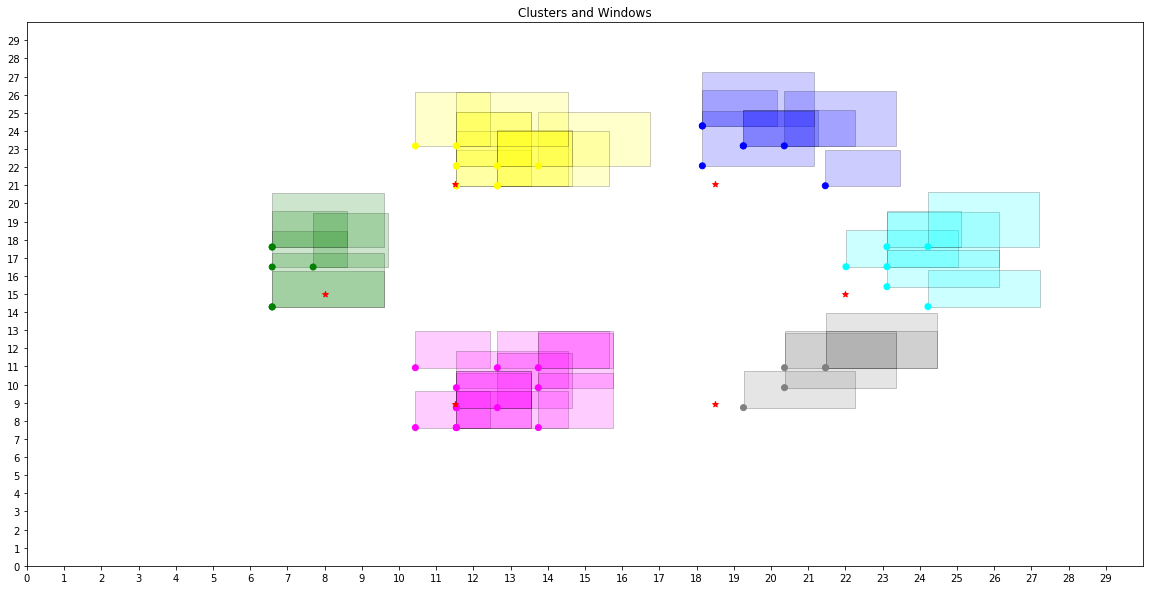

In [25]:
draw_windows(clusters, X_final, points_dims, points[:,4], n_groups, size_groups)

# 5. Debug

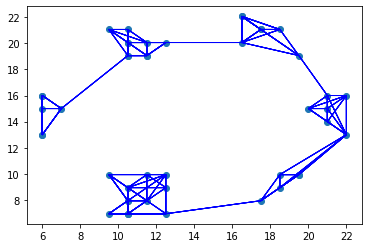

In [28]:
X = points_pos
A = adjacency_matrix(X)
scatter(X[:,0], X[:,1])
for i in range(A.shape[0]):
    for j in range(A.shape[0]):
        if(A[i,j] != 0):
            arrow(X[i,0],X[i,1], X[j,0] - X[i,0], X[j,1] - X[i,1], shape='full', color='b')
show()

<Figure size 432x288 with 0 Axes>

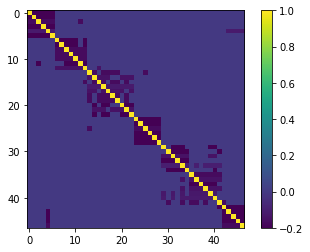

In [29]:
G = laplacian_graph(X)
clf()
fig, ax = subplots()
aa = ax.imshow(G)
cbar = fig.colorbar(aa)